# Plan 

## 1. Introduction

## 2. Importation

## 3. Description des données

## 4. Feature Engineering

## 5. Modélisation
     5.1. Dummy Regressor
     5.2. Régression logistique
     5.3. RandomForrestClassifier
     5.4. GradientBoosting Classifier
     5.5. XGBCClassifier

## 6. Rééquilibrage
     6.1. Oversampling
     6.2. Undersampling
     6.3. Class_weight
     6.4. Modification de seuil
     6.5. Features importance

## 7. Modèle final et exportation

## 8. Data drift







# 1. INTRODUCTION



La société financière souhaite développer un modèle de scoring pour prédire la probabilité de défaut de paiement des clients demandant des crédits à la consommation. Parallèlement, elle souhaite créer un tableau de bord interactif pour expliquer les décisions d'octroi de crédit et offrir aux clients un accès transparent à leurs informations.

Mission:
1. Modèle de scoring : Construire un modèle de scoring prédictif en utilisant différentes sources de données, en s'appuyant sur un kernel Kaggle adapté.

2. Dashboard interactif : Créer un tableau de bord interactif pour les chargés de relation client, permettant d'interpréter les prédictions du modèle et d'améliorer la connaissance client, tout en offrant aux clients un accès transparent à leurs informations personnelles.

En réalisant ces deux objectifs, la société pourra évaluer les risques de défaut de paiement et répondre aux attentes de transparence des clients.

# 2. IMPORTATION



In [1]:
# Data Manipulation and Computation:
import numpy as np
import pandas as pd

# Data Visualization:
import seaborn as sns
import matplotlib.pyplot as plt

# Machine Learning - Preprocessing:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer

# Machine Learning - Model Selection & Validation:
from sklearn.model_selection import train_test_split, KFold, GridSearchCV

# Machine Learning - Models and Estimators:
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from xgboost import XGBClassifier

# Machine Learning - Metrics & Evaluation:
from sklearn.metrics import (roc_curve, auc, accuracy_score, roc_auc_score, f1_score, 
                             precision_score, recall_score, classification_report, 
                             confusion_matrix, make_scorer)

# Machine Learning - Resampling & Handling Imbalanced Datasets:
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Hyperparameter Optimization:
from hyperopt import hp, fmin, tpe

# File and System Operations:
import joblib
import re
import os
import glob
import gc

# Pandas Display Options:
pd.set_option('display.max_columns', 300)
pd.set_option('display.max_row', 500)
pd.set_option('display.max_colwidth', 200)




In [2]:
#from google.colab import drive
#drive.mount('/content/drive')
#test_path = '/content/drive/MyDrive/openclass/application_test.csv'
#train_path = '/content/drive/MyDrive/openclass/application_train.csv'
#test = pd.read_csv(test_path)
#train = pd.read_csv(train_path)

ModuleNotFoundError: No module named 'google'

In [ ]:
def data_describe(folder):
    '''Vérifiez le nombre de lignes, de colonnes, de valeurs manquantes et de doublons.
       Comptez le type de colonnes.
       Indication de mémoire'''


    data_dict = {}
    for file in folder:
        try:
            data = pd.read_csv(file, encoding='utf-8')
        except UnicodeDecodeError:
            data = pd.read_csv(file, encoding='latin-1')

        # Extraire uniquement le nom du fichier sans le chemin complet
        filename = os.path.basename(file)

        data_dict[filename] = [data.shape[0],
                               data.shape[1],
                               round(data.isna().sum().sum() / data.size * 100, 2),
                               round(data.duplicated().sum().sum() / data.size * 100, 2),
                               data.select_dtypes(include=['object']).shape[1],
                               data.select_dtypes(include=['float']).shape[1],
                               data.select_dtypes(include=['int']).shape[1],
                               data.select_dtypes(include=['bool']).shape[1],
                               round(data.memory_usage().sum() / 1024 ** 2, 3)]

    comparative_table = pd.DataFrame.from_dict(data=data_dict,
                                               columns=['Rows', 'Columns', '%NaN', '%Duplicate',
                                                        'object_dtype', 'float_dtype', 'int_dtype',
                                                        'bool_dtype', 'MB_Memory'],
                                               orient='index')
    print("SUMMARY FILES…")
    return comparative_table

# Utilisation de glob.glob pour obtenir la liste des fichiers CSV
file_list = glob.glob('home\projet7\datta\*.csv')

# Appel de la fonction data_describe avec la liste des fichiers
summary_table = data_describe(folder=file_list)

# Affichage du résumé des données
print(summary_table)

SUMMARY FILES…
                                        Rows  Columns   %NaN  %Duplicate  \
application_test.csv                   48744      121  23.81         0.0   
application_train.csv                 307511      122  24.40         0.0   
bureau.csv                           1716428       17  13.50         0.0   
bureau_balance.csv                  27299925        3   0.00         0.0   
credit_card_balance.csv              3840312       23   6.65         0.0   
HomeCredit_columns_description.csv       219        5  12.15         0.0   
installments_payments.csv           13605401        8   0.01         0.0   
POS_CASH_balance.csv                10001358        8   0.07         0.0   
previous_application.csv             1670214       37  17.98         0.0   
sample_submission.csv                  48744        2   0.00         0.0   

                                    object_dtype  float_dtype  int_dtype  \
application_test.csv                          16           65         40

In [99]:
test = pd.read_csv("application_test.csv")

train = pd.read_csv("application_train.csv")

In [100]:
train_columns = set(train.columns)
test_columns = set(test.columns)

different_columns = train_columns.symmetric_difference(test_columns)
print("La différence entre les deux bases de donnèes : ", different_columns)

La différence entre les deux bases de donnèes :  {'TARGET'}


In [101]:
if 'TARGET' in train_columns and 'TARGET' not in test_columns:
    print("La colonne 'TARGET' est présente uniquement dans le dataset 'train'.")
else:
    print("La colonne 'TARGET' est soit absente dans le dataset 'train', soit présente dans le dataset 'test' ou dans les deux.")

La colonne 'TARGET' est présente uniquement dans le dataset 'train'.


# 3. DESCRIPTION DES DONNES : 

In [ ]:
def description_data(data):
    '''
    Retourne la description d'un ensemble de données.

    Paramètres :
        data : dataframe

    Retourne :
        Les 3 premières lignes du dataframe
        La forme, les types, le nombre de valeurs nulles, manquantes
        le nombre de valeurs uniques, le nombre de valeurs dupliquées

    '''
    print(f'Taille : {data.shape}')

    print("__*40")
    display(data.head(5))
    print("__*40")
    print(f"Nombre de doublons : {data.duplicated().sum()}")

    print("__*40")
    print("Informations sur les variables : ")
    for col in data:
        unique_values = data[col].nunique()
        col_type = f'({data[col].dtype})'
        print(f'{col}: {col_type}, {unique_values} valeurs différentes')
    print("__*40")
    print("Valeurs manquantes par colonnes (%): ")
    missing_percentage = data.isnull().mean() * 100
    missing_percentage = missing_percentage.sort_values(ascending=False)
    display(missing_percentage)

    print("__*40")
    print("Heatmap des valeurs manquantes :")
    plt.figure(figsize=(12, 8))  # Ajuster la taille de la figure
    sns.heatmap(data.isnull(), cmap='viridis', cbar=False)
    plt.show()


Taille : (307511, 122)
__*40


SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   ...  FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...                 0                0                0                0   
1  ...                 0                0                0                0   
2  ...                 0                0                0                0   
3  ...                 0                0                0                0   
4  ...                 0                0                0                0   

  AMT_REQ_CREDIT_BUREAU_HOUR AMT_REQ_CREDIT_BUREAU_DAY  \
0                        0.0                       0.0   
1                        0.0                       0.0   
2                        0.0                       0.0   
3                        NaN                       NaN   
4                        0.0                       0.0   

   AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                         0.0                        0.0   
1                         0.0                        0.0   
2                         0.0                        0.0   
3                         NaN                        NaN   
4                         0.0                        0.0   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
0                        0.0                         1.0  
1                        0.0                         0.0  
2                        0.0                         0.0  
3                        NaN                         NaN  
4                        0.0                         0.0  

[5 rows x 122 columns]

__*40
Nombre de doublons : 0
__*40
Informations sur les variables : 
SK_ID_CURR: (int64), 307511 valeurs différentes
TARGET: (int64), 2 valeurs différentes
NAME_CONTRACT_TYPE: (object), 2 valeurs différentes
CODE_GENDER: (object), 3 valeurs différentes
FLAG_OWN_CAR: (object), 2 valeurs différentes
FLAG_OWN_REALTY: (object), 2 valeurs différentes
CNT_CHILDREN: (int64), 15 valeurs différentes
AMT_INCOME_TOTAL: (float64), 2548 valeurs différentes
AMT_CREDIT: (float64), 5603 valeurs différentes
AMT_ANNUITY: (float64), 13672 valeurs différentes
AMT_GOODS_PRICE: (float64), 1002 valeurs différentes
NAME_TYPE_SUITE: (object), 7 valeurs différentes
NAME_INCOME_TYPE: (object), 8 valeurs différentes
NAME_EDUCATION_TYPE: (object), 5 valeurs différentes
NAME_FAMILY_STATUS: (object), 6 valeurs différentes
NAME_HOUSING_TYPE: (object), 6 valeurs différentes
REGION_POPULATION_RELATIVE: (float64), 81 valeurs différentes
DAYS_BIRTH: (int64), 17460 valeurs différentes
DAYS_EMPLOYED: (int64), 12574 valeurs

COMMONAREA_MEDI             69.872297
COMMONAREA_AVG              69.872297
COMMONAREA_MODE             69.872297
NONLIVINGAPARTMENTS_MODE    69.432963
NONLIVINGAPARTMENTS_AVG     69.432963
                              ...    
NAME_HOUSING_TYPE            0.000000
NAME_FAMILY_STATUS           0.000000
NAME_EDUCATION_TYPE          0.000000
NAME_INCOME_TYPE             0.000000
SK_ID_CURR                   0.000000
Length: 122, dtype: float64

__*40
Heatmap des valeurs manquantes :


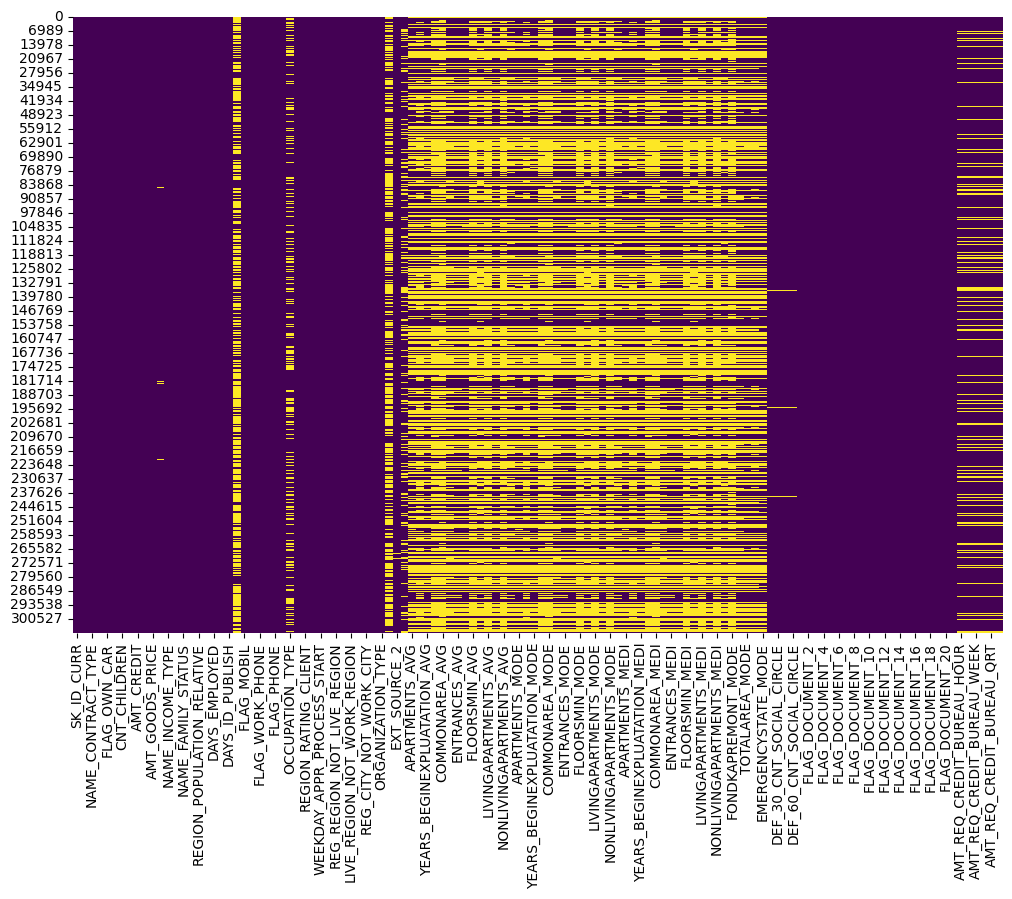

In [ ]:
description_data(train)

<Axes: title={'center': 'Répartition des types de colonnes'}, ylabel='count'>

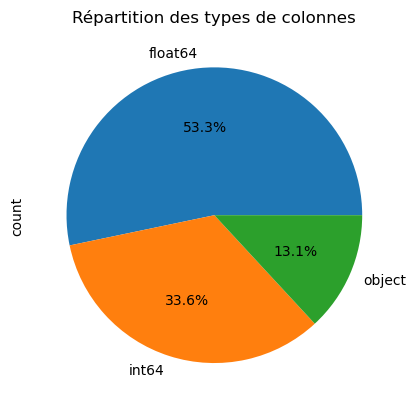

In [184]:
train.dtypes.value_counts().plot(kind='pie',autopct="%1.1f%%", title = "Répartition des types de colonnes")

#### Principales Variables
En regardant juste les noms des variables

- 'TARGET' : La variable cible indiquant si le client a connu un défaut de paiement.
- 'AMT_INCOME_TOTAL' : Le revenu total du client, qui est un indicateur important de sa capacité à rembourser le prêt.
- 'AMT_CREDIT' : Le montant total du crédit demandé par le client, qui peut être un indicateur de son niveau d'endettement.
- 'AMT_ANNUITY' : Le montant de l'annuité du prêt, qui est le montant à rembourser périodiquement.
- 'NAME_EDUCATION_TYPE' : Le niveau d'éducation du client, qui peut être lié à sa stabilité financière et à sa capacité à rembourser le prêt.
- 'DAYS_BIRTH' : L'âge du client exprimé en jours, qui peut être corrélé avec sa stabilité financière et sa capacité à rembourser le prêt.
- 'NAME_FAMILY_STATUS' : Le statut familial du client, qui peut influencer sa situation financière et sa responsabilité financière.
- 'CNT_CHILDREN' : Le nombre d'enfants à charge du client, qui peut affecter sa capacité à rembourser le prêt.
- 'OCCUPATION_TYPE' : La catégorie de l'occupation professionnelle du client, qui peut être liée à sa stabilité financière.
- 'REGION_POPULATION_RELATIVE' : La population relative de la région où vit le client, qui peut avoir un impact sur sa situation économique locale.
- 'NAME_CONTRACT_TYPE' : Le type de contrat du prêt, qui peut influencer les conditions de remboursement et la probabilité de défaut.
- 'DAYS_EMPLOYED' : Le nombre de jours depuis que le client est employé, qui peut être un indicateur de stabilité financière et de capacité à rembourser.



In [237]:
train['TARGET'].value_counts()

TARGET
0    282686
1     24825
Name: count, dtype: int64

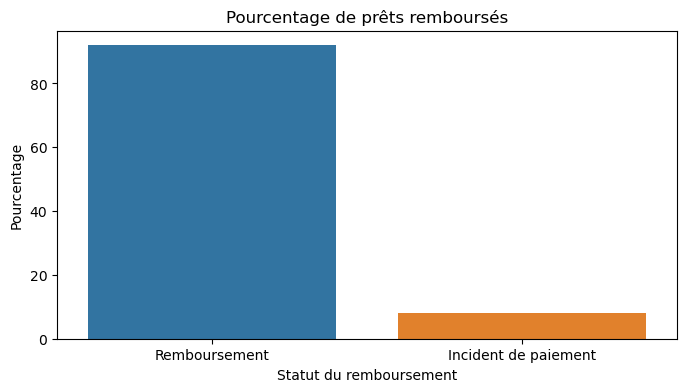

In [238]:
payment_count = train['TARGET'].value_counts()
payment_percentage = payment_count / len(train) * 100

plt.figure(figsize=(8, 4))  # Ajuster la taille de la figure

sns.barplot(x=payment_percentage.index, y=payment_percentage)

plt.xlabel('Statut du remboursement')
plt.ylabel('Pourcentage')
plt.title('Pourcentage de prêts remboursés')
plt.xticks(ticks=range(len(payment_percentage.index)), labels=["Remboursement", "Incident de paiement"])
plt.show()

Le pourcentage de défault est de presque 90%. 

In [102]:
train.CODE_GENDER.value_counts()

CODE_GENDER
F      202448
M      105059
XNA         4
Name: count, dtype: int64

On supprime le genre XNA : 

In [103]:
train = train[train.CODE_GENDER != 'XNA']

In [104]:
train['NAME_FAMILY_STATUS'].value_counts()

NAME_FAMILY_STATUS
Married                 196429
Single / not married     45444
Civil marriage           29774
Separated                19770
Widow                    16088
Unknown                      2
Name: count, dtype: int64

On spprime le statut familial inconnu : 

In [105]:
train = train[train['NAME_FAMILY_STATUS'] != 'Unknown']

On supprime les caractères spéciaux : 

In [106]:
def cleaning_cat(col):
    '''
    Nettoie une phrase en supprimant les caractères spéciaux et la convertit en majuscules.

    Paramètres :
        col : phrase à nettoyer

    Retourne :
        La phrase nettoyée en majuscules
    '''
    col = str(col).replace('-', '').replace('+', '').replace('/', ' ').replace(':', '_')
    col = str(col).upper()
    return col


In [107]:
colms_to_clean = ["NAME_CONTRACT_TYPE", "NAME_TYPE_SUITE", "OCCUPATION_TYPE", "WALLSMATERIAL_MODE", "HOUSETYPE_MODE",
                  "NAME_HOUSING_TYPE", "NAME_FAMILY_STATUS"]

In [108]:
for cols in colms_to_clean:
    train[cols] = train[cols].apply(lambda x : cleaning_cat(x))

In [109]:
train.describe().T

count           mean            std  \
SK_ID_CURR                    307505.0  278181.821811  102790.177600   
TARGET                        307505.0       0.080730       0.272421   
CNT_CHILDREN                  307505.0       0.417050       0.722120   
AMT_INCOME_TOTAL              307505.0  168796.661716  237124.848430   
AMT_CREDIT                    307505.0  599028.395296  402493.886647   
AMT_ANNUITY                   307493.0   27108.638224   14493.840051   
AMT_GOODS_PRICE               307229.0  538397.724489  369447.246462   
REGION_POPULATION_RELATIVE    307505.0       0.020868       0.013831   
DAYS_BIRTH                    307505.0  -16037.049495    4363.987877   
DAYS_EMPLOYED                 307505.0   63816.348794  141276.836143   
DAYS_REGISTRATION             307505.0   -4986.147994    3522.887818   
DAYS_ID_PUBLISH               307505.0   -2994.201437    1509.454886   
OWN_CAR_AGE                   104580.0      12.061121      11.944919   
FLAG_MOBIL                    307505.0       0.999997       0.001803   
FLAG_EMP_PHONE                307505.0       0.819886       0.384283   
FLAG_WORK_PHONE               307505.0       0.199356       0.399517   
FLAG_CONT_MOBILE              307505.0       0.998133       0.043164   
FLAG_PHONE                    307505.0       0.281056       0.449515   
FLAG_EMAIL                    307505.0       0.056721       0.231309   
CNT_FAM_MEMBERS               307505.0       2.152658       0.910680   
REGION_RATING_CLIENT          307505.0       2.052461       0.509036   
REGION_RATING_CLIENT_W_CITY   307505.0       2.031518       0.502739   
HOUR_APPR_PROCESS_START       307505.0      12.063378       3.265840   
REG_REGION_NOT_LIVE_REGION    307505.0       0.015144       0.122128   
REG_REGION_NOT_WORK_REGION    307505.0       0.050767       0.219521   
LIVE_REGION_NOT_WORK_REGION   307505.0       0.040656       0.197493   
REG_CITY_NOT_LIVE_CITY        307505.0       0.078174       0.268446   
REG_CITY_NOT_WORK_CITY        307505.0       0.230455       0.421125   
LIVE_CITY_NOT_WORK_CITY       307505.0       0.179555       0.383817   
EXT_SOURCE_1                  134130.0       0.502128       0.211064   
EXT_SOURCE_2                  306845.0       0.514391       0.191060   
EXT_SOURCE_3                  246541.0       0.510856       0.194843   
APARTMENTS_AVG                151446.0       0.117442       0.108241   
BASEMENTAREA_AVG              127564.0       0.088443       0.082439   
YEARS_BEGINEXPLUATATION_AVG   157500.0       0.977735       0.059224   
YEARS_BUILD_AVG               103020.0       0.752470       0.113278   
COMMONAREA_AVG                 92644.0       0.044622       0.076036   
ELEVATORS_AVG                 143616.0       0.078943       0.134577   
ENTRANCES_AVG                 152679.0       0.149726       0.100050   
FLOORSMAX_AVG                 154487.0       0.226283       0.144641   
FLOORSMIN_AVG                  98866.0       0.231895       0.161380   
LANDAREA_AVG                  124919.0       0.066334       0.081184   
LIVINGAPARTMENTS_AVG           97309.0       0.100776       0.092577   
LIVINGAREA_AVG                153157.0       0.107401       0.110565   
NONLIVINGAPARTMENTS_AVG        93994.0       0.008809       0.047732   
NONLIVINGAREA_AVG             137826.0       0.028358       0.069524   
APARTMENTS_MODE               151446.0       0.114233       0.107937   
BASEMENTAREA_MODE             127564.0       0.087544       0.084308   
YEARS_BEGINEXPLUATATION_MODE  157500.0       0.977065       0.064576   
YEARS_BUILD_MODE              103020.0       0.759635       0.110109   
COMMONAREA_MODE                92644.0       0.042554       0.074445   
ELEVATORS_MODE                143616.0       0.074491       0.132258   
ENTRANCES_MODE                152679.0       0.145194       0.100978   
FLOORSMAX_MODE                154487.0       0.222316       0.143710   
FLOORSMIN_MODE                 98866.0       0.228060       0.161160   
L

Données négatives pour les Days.

In [110]:
train['DAYS_BIRTH'].describe()

count    307505.000000
mean     -16037.049495
std        4363.987877
min      -25229.000000
25%      -19682.000000
50%      -15750.000000
75%      -12413.000000
max       -7489.000000
Name: DAYS_BIRTH, dtype: float64

In [111]:
train['DAYS_EMPLOYED'].describe()

count    307505.000000
mean      63816.348794
std      141276.836143
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

Text(0.5, 1.0, 'Age of client')

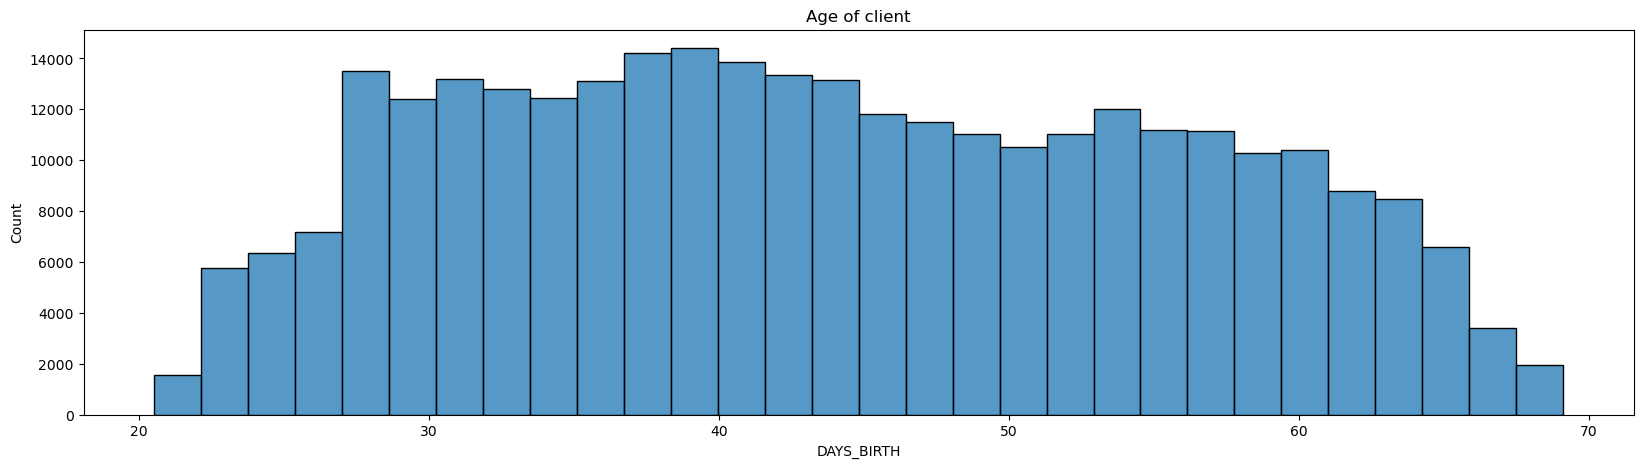

In [112]:
plt.figure(figsize=(20, 5))
sns.histplot((train['DAYS_BIRTH'] / -365), bins = 30).set_title('Age of client')

(<matplotlib.legend.Legend at 0x7f389af207f0>,
 Text(0.5, 0, 'Age(years)'),
 Text(0, 0.5, 'Density'),
 Text(0.5, 1.0, 'Distribution of Ages'))

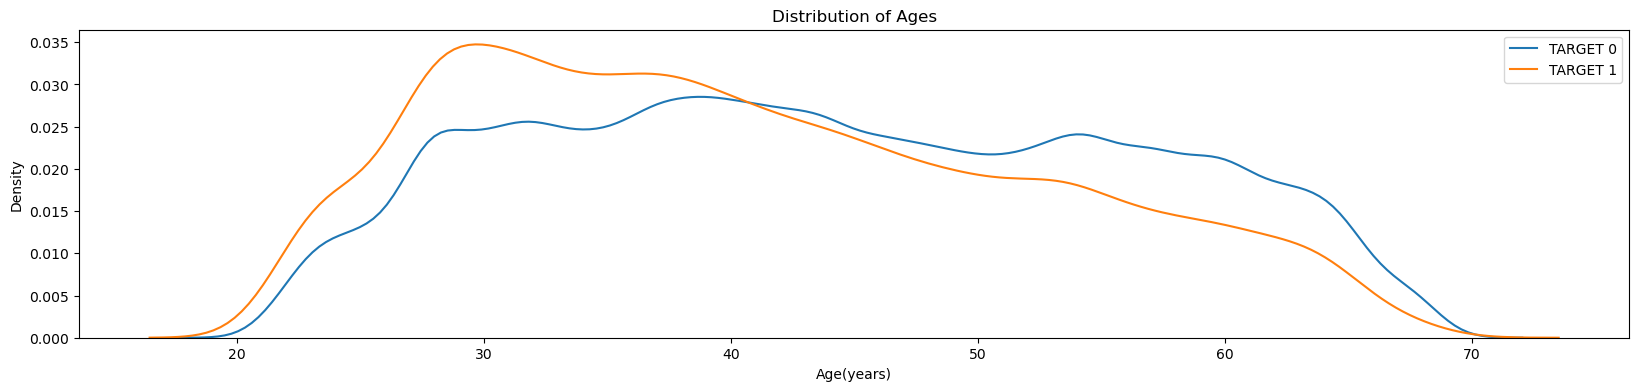

In [113]:
plt.figure(figsize = (20, 4))
sns.kdeplot(train[train['TARGET'] == 0]['DAYS_BIRTH'] / -365, label = 'TARGET 0')
sns.kdeplot(train[train['TARGET'] == 1]['DAYS_BIRTH'] / -365, label = 'TARGET 1')

plt.legend(), plt.xlabel('Age(years)'), plt.ylabel('Density'), plt.title('Distribution of Ages')

Text(0.5, 0, 'Days Employment')

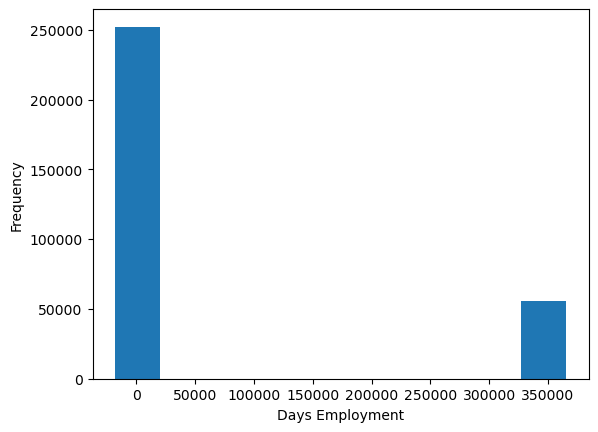

In [114]:
train['DAYS_EMPLOYED'].plot.hist();
plt.xlabel('Days Employment')

In [115]:
outliers_days = train[train['DAYS_EMPLOYED'] == 365243]
normal_days = train[train['DAYS_EMPLOYED'] != 365243]

print(outliers_days['TARGET'].mean())
print(normal_days['TARGET'].mean())


outliers_days.shape

0.05399646043269404
0.0866018062039178


(55374, 122)

Les outliers 'DAYS_EMPLOYED' ont un taux de défaut un peu plus faible.

Text(0.5, 0, 'Days Employment')

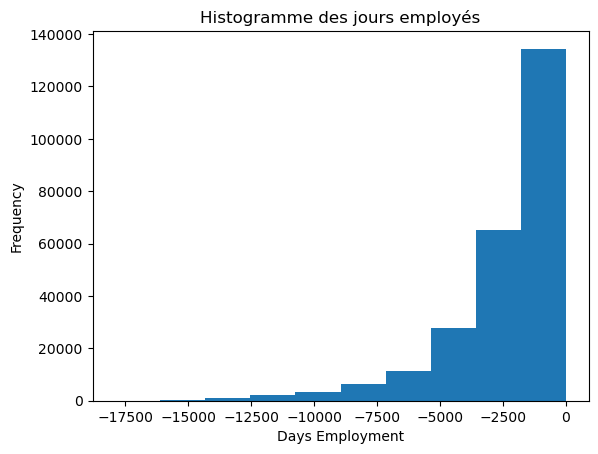

In [116]:
normal_days['DAYS_EMPLOYED'].plot.hist(title = 'Histogramme des jours employés');
plt.xlabel('Days Employment')

In [117]:
#Création d'une colonne indiquant si outlier ou pas
train['DAYS_EMPLOYED_outlier'] = train["DAYS_EMPLOYED"] == 365243

#On remplace les outliers par des nan
train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

In [16]:
# Sélection des variables quantitatives dans le dataframe train
quantitative_variables = train.select_dtypes(include=['int64', 'float64'])

# Calcul de la matrice des corrélations
correlation_matrix = quantitative_variables.corr()

# Affichage de la matrice des corrélations
correlations = train.corr()['TARGET'].sort_values()

# Top 5 corrélations positives
top_5_positive = correlations.tail(5).iloc[::-1]

# Top 5 corrélations négatives
top_5_negative = correlations.head(5)

# Top 5 corrélations faibles (en excluant les valeurs inférieures à 10% en valeur absolue)
top_5_weak = correlations[abs(correlations) < 0.1].sort_values(ascending=False).head(5)


print("Top 5 corrélations positives :")
print(top_5_positive)

print("\nTop 5 corrélations négatives :")
print(top_5_negative)

print("\nTop 5 corrélations faibles (en excluant les valeurs inférieures à 10% en valeur absolue) :")
print(top_5_weak)

/tmp/ipykernel_6026/4282697848.py:8: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlations = train.corr()['TARGET'].sort_values()


Top 5 corrélations positives :
TARGET                         1.000000
DAYS_BIRTH                     0.078244
DAYS_EMPLOYED                  0.074959
REGION_RATING_CLIENT_W_CITY    0.060895
REGION_RATING_CLIENT           0.058901
Name: TARGET, dtype: float64

Top 5 corrélations négatives :
EXT_SOURCE_3            -0.178926
EXT_SOURCE_2            -0.160470
EXT_SOURCE_1            -0.155316
DAYS_EMPLOYED_outlier   -0.045990
FLOORSMAX_AVG           -0.044007
Name: TARGET, dtype: float64

Top 5 corrélations faibles (en excluant les valeurs inférieures à 10% en valeur absolue) :
DAYS_BIRTH                     0.078244
DAYS_EMPLOYED                  0.074959
REGION_RATING_CLIENT_W_CITY    0.060895
REGION_RATING_CLIENT           0.058901
DAYS_LAST_PHONE_CHANGE         0.055220
Name: TARGET, dtype: float64


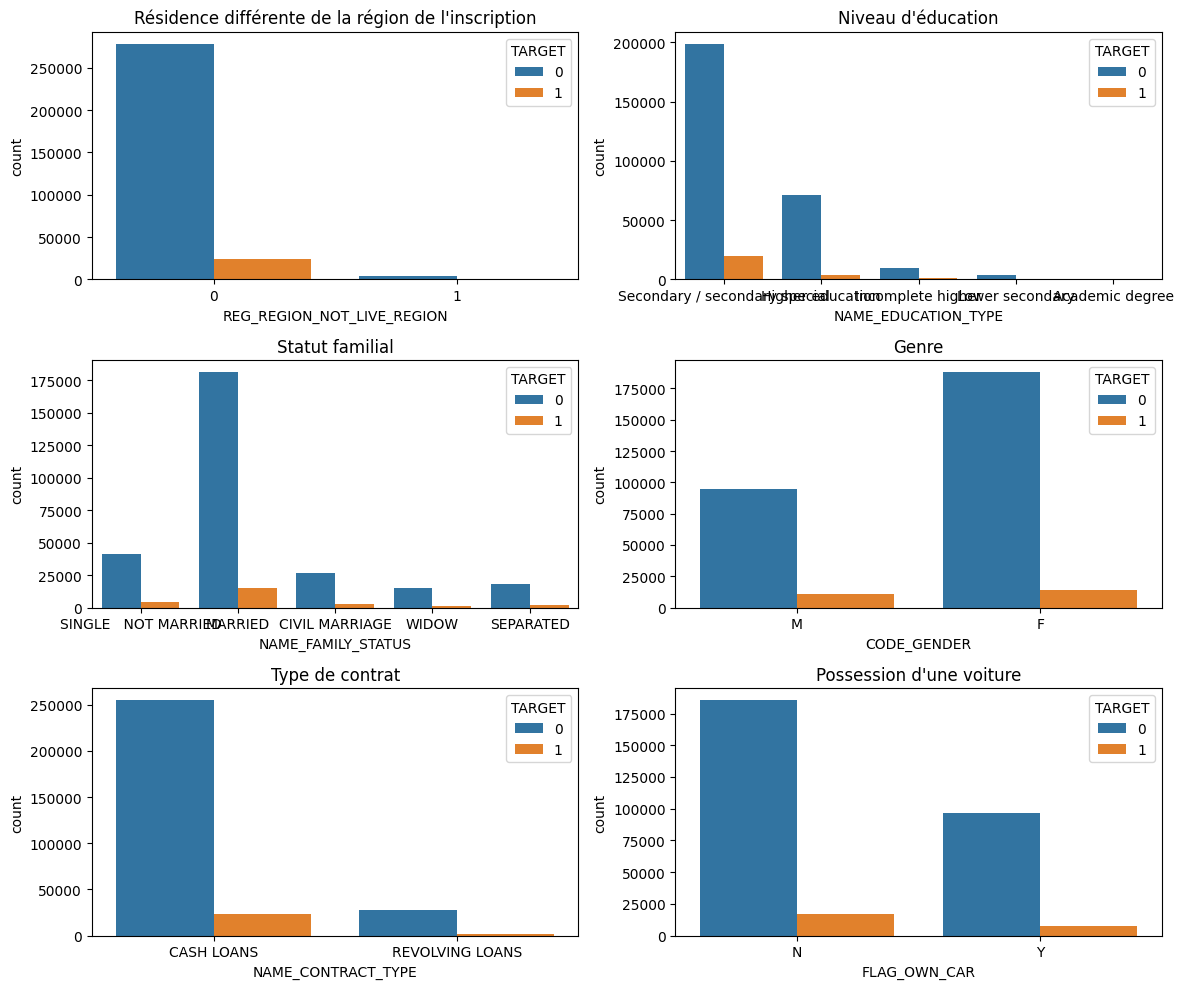

In [ ]:
# Création de la grille 3x2
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 10))

# Graphique 1 : Variable "REG_REGION_NOT_LIVE_REGION"
sns.countplot(x="REG_REGION_NOT_LIVE_REGION", hue="TARGET", data=train, ax=axes[0, 0])
axes[0, 0].set_title("Résidence différente de la région de l'inscription")

# Graphique 2 : Variable "NAME_EDUCATION_TYPE"
sns.countplot(x="NAME_EDUCATION_TYPE", hue="TARGET", data=train, ax=axes[0, 1])
axes[0, 1].set_title("Niveau d'éducation")

# Graphique 3 : Variable "NAME_FAMILY_STATUS"
sns.countplot(x="NAME_FAMILY_STATUS", hue="TARGET", data=train, ax=axes[1, 0])
axes[1, 0].set_title("Statut familial")

# Graphique 4 : Variable "CODE_GENDER"
sns.countplot(x="CODE_GENDER", hue="TARGET", data=train, ax=axes[1, 1])
axes[1, 1].set_title("Genre")

# Graphique 5 : Variable "NAME_CONTRACT_TYPE"
sns.countplot(x="NAME_CONTRACT_TYPE", hue="TARGET", data=train, ax=axes[2, 0])
axes[2, 0].set_title("Type de contrat")

# Graphique 6 : Variable "FLAG_OWN_CAR"
sns.countplot(x="FLAG_OWN_CAR", hue="TARGET", data=train, ax=axes[2, 1])
axes[2, 1].set_title("Possession d'une voiture")

# Ajustement de l'espacement entre les graphiques
plt.tight_layout()

# Affichage des graphiques
plt.show()


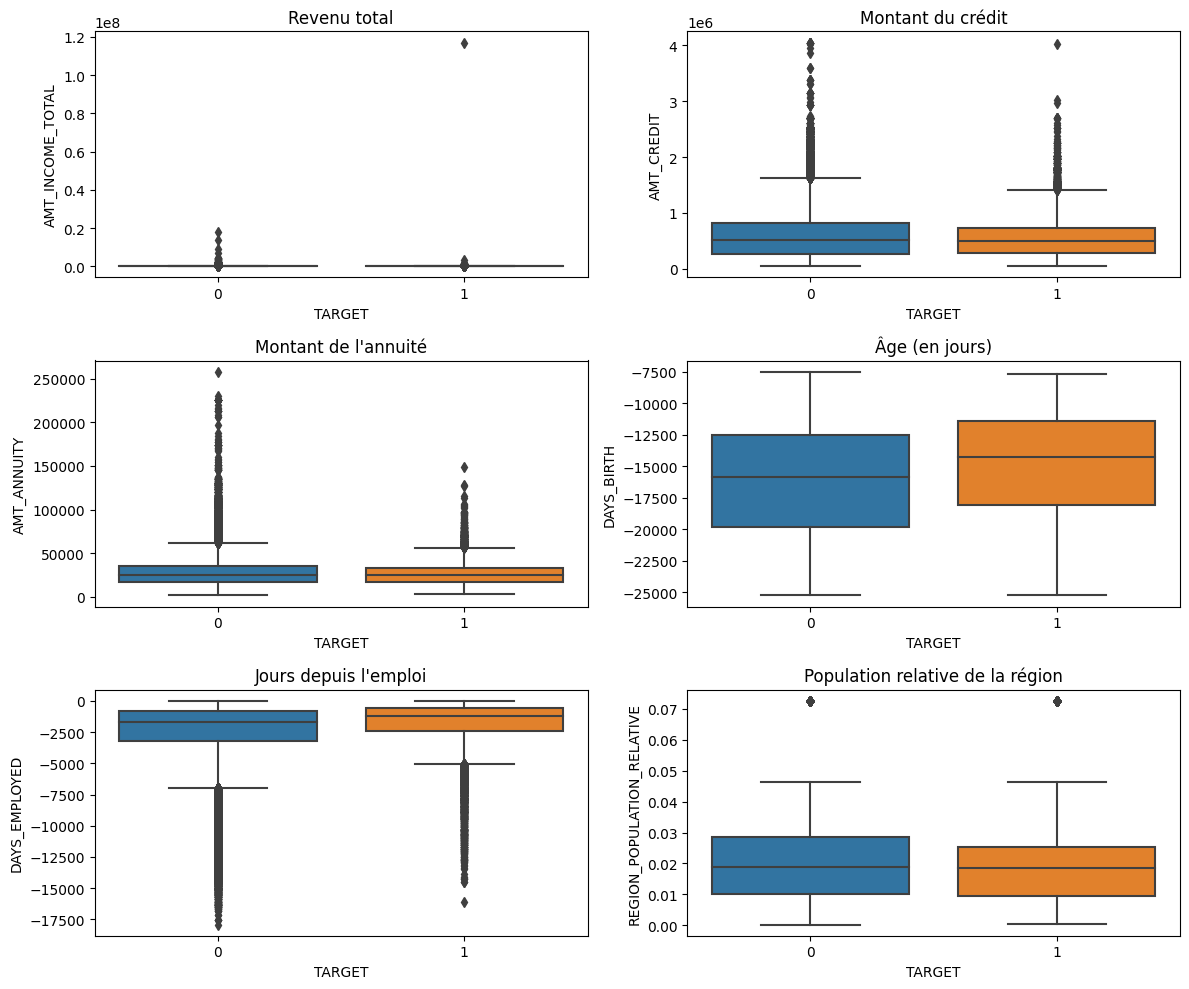

In [ ]:

# Variables quantitatives sélectionnées
quantitative_variables = ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'REGION_POPULATION_RELATIVE']

# Création de la grille 3x2
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 10))

# Graphique 1 : Variable "AMT_INCOME_TOTAL"
sns.boxplot(x="TARGET", y="AMT_INCOME_TOTAL", data=train, ax=axes[0, 0])
axes[0, 0].set_title("Revenu total")

# Graphique 2 : Variable "AMT_CREDIT"
sns.boxplot(x="TARGET", y="AMT_CREDIT", data=train, ax=axes[0, 1])
axes[0, 1].set_title("Montant du crédit")

# Graphique 3 : Variable "AMT_ANNUITY"
sns.boxplot(x="TARGET", y="AMT_ANNUITY", data=train, ax=axes[1, 0])
axes[1, 0].set_title("Montant de l'annuité")

# Graphique 4 : Variable "DAYS_BIRTH"
sns.boxplot(x="TARGET", y="DAYS_BIRTH", data=train, ax=axes[1, 1])
axes[1, 1].set_title("Âge (en jours)")

# Graphique 5 : Variable "DAYS_EMPLOYED"
sns.boxplot(x="TARGET", y="DAYS_EMPLOYED", data=train, ax=axes[2, 0])
axes[2, 0].set_title("Jours depuis l'emploi")

# Graphique 6 : Variable "REGION_POPULATION_RELATIVE"
sns.boxplot(x="TARGET", y="REGION_POPULATION_RELATIVE", data=train, ax=axes[2, 1])
axes[2, 1].set_title("Population relative de la région")

# Ajustement de l'espacement entre les graphiques
plt.tight_layout()

# Affichage des graphiques
plt.show()


# 4. FEATURE ENGINEERING : 
Le feature engineering est effectué en se basant sur le travail suivant : https://www.kaggle.com/code/jsaguiar/lightgbm-with-simple-features/script

- La variable "DAYS_EMPLOYED_PERC" représente le ratio des jours d'emploi par rapport aux jours de naissance du client. Elle peut donner une indication sur la stabilité de l'emploi et son influence potentielle sur le remboursement des prêts.

- La variable "INCOME_CREDIT_PERC" mesure le ratio entre le revenu total du client et le montant du crédit accordé. Elle permet d'évaluer la capacité financière relative du client et sa capacité à rembourser le crédit.

- La variable "INCOME_PER_PERSON" représente le revenu moyen par personne dans la famille du client. Cette variable peut fournir une indication sur le niveau de vie du ménage et son impact sur la capacité de remboursement.

- La variable "ANNUITY_INCOME_PERC" mesure le ratio entre l'annuité du prêt et le revenu total du client. Elle peut aider à évaluer la part du revenu allouée au remboursement de l'annuité et ainsi évaluer la capacité de remboursement.

- La variable "PAYMENT_RATE" représente le ratio entre l'annuité du prêt et le montant du crédit. Elle permet d'évaluer la proportion du montant du crédit qui est remboursée chaque année.

- "CREDIT_TO_ANNUITY_RATIO_BY_AGE" : Ce ratio est le produit du ratio du montant du crédit sur l'annuité du prêt par l'âge en jours du client. Il permet de prendre en compte à la fois le montant du crédit et l'âge du client dans l'évaluation de la capacité de remboursement.

- "INCOME_TO_FAMILYSIZE_RATIO" : Ce ratio représente le rapport entre le revenu total du client et le nombre de membres de sa famille. Il permet de considérer la taille de la famille dans l'évaluation de la capacité financière du client.

In [120]:
train['DAYS_EMPLOYED_PERC'] = train['DAYS_EMPLOYED'] / train['DAYS_BIRTH']
train['INCOME_CREDIT_PERC'] = train['AMT_INCOME_TOTAL'] / train['AMT_CREDIT']
train['INCOME_PER_PERSON'] = train['AMT_INCOME_TOTAL'] / train['CNT_FAM_MEMBERS']
train['ANNUITY_INCOME_PERC'] = train['AMT_ANNUITY'] / train['AMT_INCOME_TOTAL']
train['PAYMENT_RATE'] = train['AMT_ANNUITY'] / train['AMT_CREDIT']
train['CREDIT_TO_ANNUITY_RATIO_BY_AGE'] = train['AMT_CREDIT'] / train['AMT_ANNUITY'] * train['DAYS_BIRTH']
train['INCOME_TO_FAMILYSIZE_RATIO'] = train['AMT_INCOME_TOTAL'] / train['CNT_FAM_MEMBERS']


### PRÉPARATION DES DONNÈES :

- Encodage one-hot :  Cela crée de nouvelles colonnes binaires pour chaque catégorie, indiquant la présence ou l'absence de chaque catégorie dans les observations.

- Encodage par étiquette : Les variables catégorielles binaires  sont encodées en utilisant l'encodage par  étiquette numérique (0 ou 1).

- Traitement des valeurs manquantes des variables catégorielles sont considérées comme une catégorie distincte lors de l'encodage. Au lieu de remplacer les valeurs manquantes par une valeur spécifique, elles sont traitées comme une catégorie supplémentaire.

In [121]:
def cat_encoder(features):
    '''
    Effectue un encodage one-hot des variables catégorielles en utilisant la méthode get_dummies.
    Applique un encodage par étiquette (label encoding) aux variables binaires.
    Traite les valeurs manquantes comme des catégories distinctes.
    Renvoie le jeu de données encodé.

    Paramètres :
        - features : DataFrame - Jeu de données contenant les variables à encoder

    Retour :
        - features : DataFrame - Jeu de données encodé avec les variables catégorielles transformées
    '''
    label_encoder = LabelEncoder()
    categorical_columns_train = []

    for col in features:
        if col != "TARGET":
            if features[col].dtype == object:
                # Encodage par étiquette (label encoding) pour les variables binaires
                if features[col].nunique() == 2:
                    features[col] = label_encoder.fit_transform(features[col])
                # Récupération des colonnes pour lesquelles on effectue un encodage
                else:
                    categorical_columns_train.append(col)

    # Encodage one-hot
    features = pd.get_dummies(features, columns=categorical_columns_train, dummy_na=True)

    # Convertir les colonnes booléennes en int (0 et 1)
    for col in features:
        if features[col].dtype == bool:
            features[col] = features[col].astype(int)

    return features



In [122]:
features=train.copy()

# Extraction des ID
train_id = train["SK_ID_CURR"]

# Extraction des Targets
labels = train['TARGET']
#labels.reset_index(drop=True, inplace=True)

# Suppression des ID et de la cible
features = train.drop(columns=['SK_ID_CURR', 'TARGET'])

# Séparation des variables catégorielles et des autres variables
categorical_features = features.select_dtypes(include=['object', 'bool'])
numeric_features = features.select_dtypes(exclude='object')

In [123]:
# Imputation des valeurs manquantes pour les variables numériques
numeric_imputer = SimpleImputer(strategy='median')
numeric_features_imputed = numeric_imputer.fit_transform(numeric_features)

# Imputation des valeurs manquantes pour les variables catégorielles
categorical_imputer = SimpleImputer(strategy='most_frequent')
categorical_features_imputed = categorical_imputer.fit_transform(categorical_features)

In [124]:
# Encodage des variables catégorielles
categorical_features_encoded = cat_encoder(pd.DataFrame(categorical_features_imputed, columns=categorical_features.columns))

# Extraction des noms des Features
features_name = list(numeric_features.columns) + list(categorical_features_encoded.columns)

# Mise à l'échelle des features numériques
scaler = MinMaxScaler(feature_range=(0, 1))
numeric_features_scaled = scaler.fit_transform(numeric_features_imputed)

In [125]:
# Reconstruction du DataFrame avec les variables mises à l'échelle et les variables catégorielles encodées
features_data = pd.DataFrame(numeric_features_scaled, columns=numeric_features.columns)
features_data = pd.concat([features_data, categorical_features_encoded], axis=1)

# Ajout de la colonne TARGET et des IDs
features_data['TARGET'] = labels
features_data["SK_ID_CURR"] = train_id

# Passage des IDs en index
features_data.set_index('SK_ID_CURR', inplace=True)

features_data.shape

/tmp/ipykernel_253329/3886913056.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  features_data['TARGET'] = labels
/tmp/ipykernel_253329/3886913056.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  features_data["SK_ID_CURR"] = train_id


(307505, 262)

In [126]:
features_data.sample(10)

CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
SK_ID_CURR                                                            
128975.0        0.000000          0.000935    0.224719     0.158617   
118098.0        0.000000          0.000550    0.210697     0.108775   
294347.0        0.000000          0.013245    0.127043     0.103966   
285943.0        0.000000          0.001512    0.052360     0.090962   
225844.0        0.052632          0.000742    0.033708     0.028800   
383789.0        0.000000          0.000358    0.115729     0.072850   
415347.0        0.000000          0.000281    0.033708     0.063636   
235715.0        0.052632          0.001704    0.302472     0.152264   
365454.0        0.000000          0.000935    0.070139     0.043928   
241228.0        0.000000          0.000935    0.101124     0.040505   

            AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
SK_ID_CURR                                                            
128975.0           0.225589                    0.248124    0.157835   
118098.0           0.158249                    0.088357    0.436133   
294347.0           0.113356                    0.446855    0.363698   
285943.0           0.046016                    1.000000    0.052198   
225844.0           0.034792                    0.136490    0.872830   
383789.0           0.103255                    0.260475    0.170293   
415347.0           0.034792                    0.097136    0.024972   
235715.0           0.214366                    0.096707    0.774746   
365454.0           0.051627                    0.118752    0.945716   
241228.0           0.102132                    0.248124    0.588388   

            DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  \
SK_ID_CURR                                                                   
128975.0         0.907995           0.814040         0.417257     0.186813   
118098.0         0.981856           0.986746         0.855356     0.098901   
294347.0         0.959022           0.780642         0.681673     0.098901   
285943.0         0.907995           0.417558         0.479783     0.098901   
225844.0         0.887896           0.778656         0.665694     0.098901   
383789.0         0.907995           0.736503         0.395720     0.098901   
415347.0         0.907995           0.829564         0.420175     0.098901   
235715.0         0.992910           0.847479         0.469362     0.197802   
365454.0         0.913075           0.959144         0.844102     0.087912   
241228.0         0.951932           0.938635         0.692650     0.098901   

            FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  \
SK_ID_CURR                                                                  
128975.0           1.0             0.0              0.0               1.0   
118098.0           1.0             1.0              0.0               1.0   
294347.0           1.0             1.0              0.0               1.0   
285943.0           1.0             0.0              0.0               1.0   
225844.0           1.0             1.0              0.0               1.0   
383789.0           1.0             0.0              0.0               1.0   
415347.0           1.0             0.0              0.0               1.0   
235715.0           1.0             1.0              0.0               1.0   
365454.0           1.0             1.0              0.0               1.0   
241228.0           1.0             1.0              0.0               1.0   

            FLAG_PHONE  FLAG_EMAIL  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
SK_ID_CURR                                                                  
128975.0           0.0         0.0         0.052632                   1.0   
118098.0           0.0         0.0         0.000000                   0.5   
294347.0           0.0         0.0         0.052632                   0.0   
285943.0           1.0         0.0         0.000000        

In [127]:
features_data.isna().sum()

CNT_CHILDREN                                         0
AMT_INCOME_TOTAL                                     0
AMT_CREDIT                                           0
AMT_ANNUITY                                          0
AMT_GOODS_PRICE                                      0
REGION_POPULATION_RELATIVE                           0
DAYS_BIRTH                                           0
DAYS_EMPLOYED                                        0
DAYS_REGISTRATION                                    0
DAYS_ID_PUBLISH                                      0
OWN_CAR_AGE                                          0
FLAG_MOBIL                                           0
FLAG_EMP_PHONE                                       0
FLAG_WORK_PHONE                                      0
FLAG_CONT_MOBILE                                     0
FLAG_PHONE                                           0
FLAG_EMAIL                                           0
CNT_FAM_MEMBERS                                      0
REGION_RAT

In [97]:
features_data.dropna(inplace=True)

In [98]:
#features_data.to_csv('features_data')

In [2]:
features_data = pd.read_csv("features_data.csv")
features_data.set_index('SK_ID_CURR', inplace=True)


In [3]:
features_data.head()

CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
SK_ID_CURR                                                            
100002.0             0.0          0.001512    0.090287     0.090032   
100003.0             0.0          0.002089    0.311736     0.132924   
100004.0             0.0          0.000358    0.022472     0.020025   
100006.0             0.0          0.000935    0.066837     0.109477   
100007.0             0.0          0.000819    0.116854     0.078975   

            AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
SK_ID_CURR                                                            
100002.0           0.077441                    0.256321    0.888839   
100003.0           0.271605                    0.045016    0.477066   
100004.0           0.023569                    0.134897    0.348500   
100006.0           0.063973                    0.107023    0.350810   
100007.0           0.117845                    0.392880    0.298561   

            DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  \
SK_ID_CURR                                                                   
100002.0         0.964437           0.852140         0.705433     0.098901   
100003.0         0.933676           0.951929         0.959566     0.098901   
100004.0         0.987439           0.827335         0.648326     0.285714   
100006.0         0.830337           0.601451         0.661387     0.098901   
100007.0         0.830393           0.825268         0.519522     0.098901   

            FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  \
SK_ID_CURR                                                                  
100002.0           1.0             1.0              0.0               1.0   
100003.0           1.0             1.0              0.0               1.0   
100004.0           1.0             1.0              1.0               1.0   
100006.0           1.0             1.0              0.0               1.0   
100007.0           1.0             1.0              0.0               1.0   

            FLAG_PHONE  FLAG_EMAIL  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
SK_ID_CURR                                                                  
100002.0           1.0         0.0         0.000000                   0.5   
100003.0           1.0         0.0         0.052632                   0.0   
100004.0           1.0         0.0         0.000000                   0.5   
100006.0           0.0         0.0         0.052632                   0.5   
100007.0           0.0         0.0         0.000000                   0.5   

            REGION_RATING_CLIENT_W_CITY  HOUR_APPR_PROCESS_START  \
SK_ID_CURR                                                         
100002.0                            0.5                 0.434783   
100003.0                            0.0                 0.478261   
100004.0                            0.5                 0.391304   
100006.0                            0.5                 0.739130   
100007.0                            0.5                 0.478261   

            REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
SK_ID_CURR                                                           
100002.0                           0.0                         0.0   
100003.0                           0.0                         0.0   
100004.0                           0.0                         0.0   
100006.0                           0.0                         0.0   
100007.0                           0.0                         0.0   

            LIVE_REGION_NOT_WORK_REGION  REG_CITY_NOT_LIVE_CITY  \
SK_ID_CURR                                                        
100002.0                            0.0                     0.0   
100003.0                            0.0                     0.0   
100004.0                            0.0                     0.0   
100006.0                            0.0                     0.0   
100007.0           

In [4]:
data_X = features_data.drop(columns = 'TARGET')
data_y = features_data['TARGET']

# Séparation des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.2, random_state=42)

# Affichage des dimensions des ensembles d'entraînement et de test
print("Dimensions de l'ensemble d'entraînement :", X_train.shape)
print("Dimensions de l'ensemble de test :", X_test.shape)
print("Dimensions du target d'entraînement :", y_train.shape)
print("Dimensions du target de test :", y_test.shape)

Dimensions de l'ensemble d'entraînement : (245999, 261)
Dimensions de l'ensemble de test : (61500, 261)
Dimensions du target d'entraînement : (245999,)
Dimensions du target de test : (61500,)


In [5]:
# Liste des caractères spéciaux à supprimer
special_chars = '[^A-Za-z0-9_]+'

# Renommage des variables dans le DataFrame
X_train = X_train.rename(columns=lambda x: re.sub(special_chars, '', x))
X_test = X_test.rename(columns=lambda x: re.sub(special_chars, '', x))

# 5. MODELISATION :

## 5.1 Dummy Regressor

In [15]:
# Création et entraînement du modèle DummyRegressor
dummy_model = DummyRegressor(strategy='constant', constant=0)
dummy_model.fit(X_train, y_train)

# Prédictions sur les données de test
predictions_dummy = dummy_model.predict(X_test)

In [16]:
# Calcul de l'AUC-ROC
auc_roc = roc_auc_score(y_test, predictions_dummy)
print('AUC : %0.4f' % auc_roc)

# Affichage du rapport de classification
print(classification_report(y_test, predictions_dummy, zero_division=0))

AUC : 0.5000
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     56493
         1.0       0.00      0.00      0.00      5007

    accuracy                           0.92     61500
   macro avg       0.46      0.50      0.48     61500
weighted avg       0.84      0.92      0.88     61500



In [17]:
def evaluate_model(model, X_test, y_test, threshold=0.5):
    # Probabilités prédictives pour la classe positive
    probabilities = model.predict_proba(X_test)[:, 1]
    
    # Prédictions basées sur le seuil choisi
    predictions = (probabilities >= threshold).astype(int)

    # Calcul de la matrice de confusion
    confusion = confusion_matrix(y_test, predictions)

    # Calcul des taux de faux positifs et vrais positifs pour la courbe ROC
    fpr, tpr, _ = roc_curve(y_test, probabilities)

    # Calcul de l'AUC-ROC
    auc_roc = auc(fpr, tpr)

    # Affichage de la matrice de confusion et de la courbe ROC
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Matrice de confusion
    im = axes[0].imshow(confusion, cmap=plt.cm.Blues)
    axes[0].set_xticks(np.arange(confusion.shape[1]))
    axes[0].set_yticks(np.arange(confusion.shape[0]))
    axes[0].set_xticklabels(np.arange(confusion.shape[1]))
    axes[0].set_yticklabels(np.arange(confusion.shape[0]))
    axes[0].set_xlabel('Valeurs prédites')
    axes[0].set_ylabel('Vraies valeurs')
    axes[0].set_title('Matrice de confusion')

    # Ajout des nombres et des pourcentages dans la matrice de confusion
    confusion_norm=confusion/np.sum(confusion,axis=1)[:,np.newaxis] * 100
    for i in range(confusion.shape[0]):
        for j in range(confusion.shape[1]):
            text = axes[0].text(j, i, f'{confusion[i, j]}\n({confusion_norm[i, j] :.2f}%)',
                                ha="center", va="center", color="white" if confusion[i, j] > np.sum(confusion) / 2 else "black")
    
    # Ajout de la légende pour la matrice de confusion
    fig.colorbar(im, ax=axes[0])

    # Courbe ROC
    axes[1].plot(fpr, tpr, color='b', label='Courbe ROC (AUC = %0.4f)' % auc_roc)
    axes[1].plot([0, 1], [0, 1], color='r', linestyle='--', label='Aléatoire')
    axes[1].set_xlabel('Taux de faux positifs')
    axes[1].set_ylabel('Taux de vrais positifs')
    axes[1].set_title('Courbe ROC')
    axes[1].legend(loc='lower right')

    plt.tight_layout()
    plt.show()


In [18]:
evaluate_model(dummy_model,X_test,y_test)

AttributeError: 'DummyRegressor' object has no attribute 'predict_proba'

In [228]:
import mlflow
from sklearn.metrics import mean_squared_error, r2_score

mlflow.set_tracking_uri("~/openclassroom/projet7")

# Démarrez une expérience MLflow
with mlflow.start_run():
    # Création et entraînement du modèle DummyRegressor
    strategy_param = 'constant'
    constant_param = 0
    dummy_model = DummyRegressor(strategy=strategy_param, constant=constant_param)
    dummy_model.fit(X_train, y_train)

    # Enregistrez les paramètres du modèle
    mlflow.log_param("strategy", strategy_param)
    mlflow.log_param("constant", constant_param)

    # Prédictions sur les données de test
    predictions_dummy = dummy_model.predict(X_test)

    # Calculez et enregistrez des métriques de performance
    mse = mean_squared_error(y_test, predictions_dummy)
    r2 = r2_score(y_test, predictions_dummy)
    mlflow.log_metric("mse", mse)
    mlflow.log_metric("r2", r2)

    # Enregistrez le modèle lui-même pour une utilisation ultérieure
    mlflow.sklearn.log_model(dummy_model, "model")


ModuleNotFoundError: No module named 'mlflow'

## 5.2 Régression logistique

In [9]:
# Création du modèle LogisticRegression avec les hyperparamètres souhaités
lr = LogisticRegression(C=0.001, max_iter=100)

# Entraînement du modèle sur les données d'entraînement
lr.fit(X_train, y_train)

# Prédictions sur les données de test
predictions_lr = lr.predict(X_test)

# Calcul de l'AUC-ROC
roc_auc = roc_auc_score(y_test, lr.predict_proba(X_test)[:, 1])
print('AUC : %0.4f' % roc_auc)

# Affichage du rapport de classification
print(classification_report(y_test, predictions_lr, zero_division=0))

AUC : 0.5232
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     56493
         1.0       0.00      0.00      0.00      5007

    accuracy                           0.92     61500
   macro avg       0.46      0.50      0.48     61500
weighted avg       0.84      0.92      0.88     61500



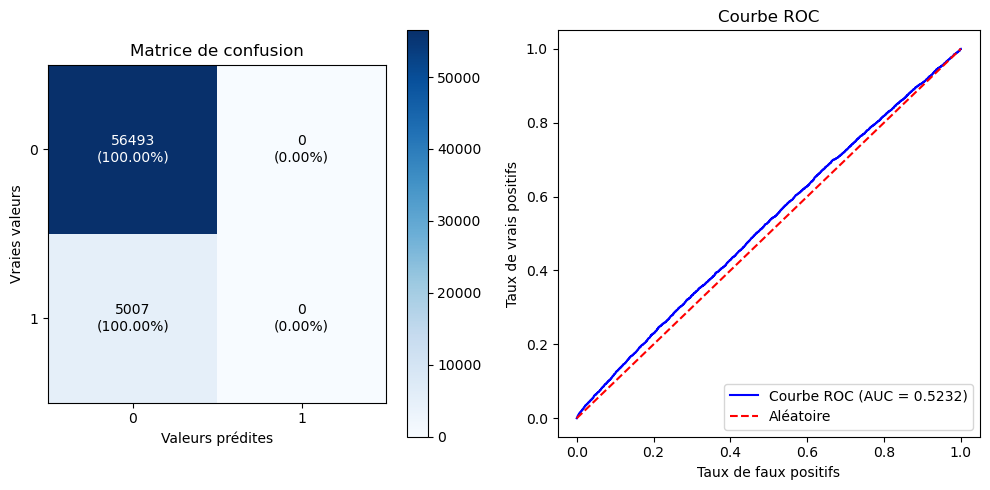

In [10]:
evaluate_model(lr, X_test, y_test)

In [11]:
import mlflow
import mlflow.sklearn
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression

# Assurez-vous d'avoir défini votre MLflow tracking URI
mlflow.set_tracking_uri("~/openclassroom/projet7")

# Démarrez une nouvelle expérience ou utilisez une existante
mlflow.set_experiment("Logistic_Regression_Experiment")

# Démarrez une nouvelle exécution
with mlflow.start_run():
    # Création du modèle LogisticRegression avec les hyperparamètres souhaités
    lr = LogisticRegression(C=0.001, max_iter=100)

    # Entraînement du modèle sur les données d'entraînement
    lr.fit(X_train, y_train)

    # Prédictions sur les données de test
    predictions_lr = lr.predict(X_test)

    # Calcul de l'AUC-ROC
    roc_auc = roc_auc_score(y_test, lr.predict_proba(X_test)[:, 1])
    print('AUC : %0.4f' % roc_auc)

    # Log metrics
    mlflow.log_metric("roc_auc", roc_auc)
    
    # Affichage du rapport de classification
    report = classification_report(y_test, predictions_lr, zero_division=0, output_dict=True)
    
    # Log metrics from the report
    mlflow.log_metric("precision_0", report["0"]["precision"])
    mlflow.log_metric("recall_0", report["0"]["recall"])
    mlflow.log_metric("f1_score_0", report["0"]["f1-score"])
    
    mlflow.log_metric("precision_1", report["1"]["precision"])
    mlflow.log_metric("recall_1", report["1"]["recall"])
    mlflow.log_metric("f1_score_1", report["1"]["f1-score"])

    # Log the model
    mlflow.sklearn.log_model(lr, "model")


2023/10/07 02:54:17 INFO mlflow.tracking.fluent: Experiment with name 'Logistic_Regression_Experiment' does not exist. Creating a new experiment.


AUC : 0.5232


KeyError: '0'

## 5.3 RandomForrestClassifier

In [63]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report

# Création du modèle Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Entraînement du modèle sur les données d'entraînement
rf_model.fit(X_train, y_train)

# Prédictions sur les données de test
predictions = rf_model.predict(X_test)

# Calcul de l'AUC-ROC
roc_auc = roc_auc_score(y_test, rf_model.predict_proba(X_test)[:, 1])
print('AUC : %0.4f' % roc_auc)

# Affichage du rapport de classification
print(classification_report(y_test, predictions, zero_division=0))


AUC : 0.5884
              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96     56493
         1.0       1.00      0.09      0.16      5007

    accuracy                           0.93     61500
   macro avg       0.96      0.54      0.56     61500
weighted avg       0.93      0.93      0.90     61500



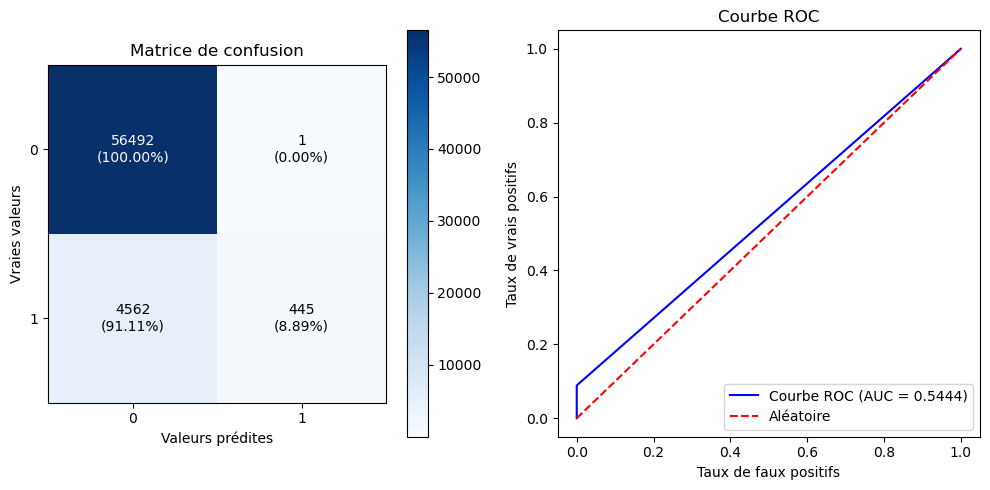

In [64]:
evaluate_model(rf_model, X_test, y_test)

## 5.4 GardientBoosting Classifier

In [65]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, classification_report

# Création du modèle Gradient Boosting Classifier
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)

# Entraînement du modèle sur les données d'entraînement
gb_model.fit(X_train, y_train)

# Prédictions sur les données de test
predictions = gb_model.predict(X_test)

# Calcul de l'AUC-ROC
roc_auc = roc_auc_score(y_test, gb_model.predict_proba(X_test)[:, 1])
print('AUC : %0.4f' % roc_auc)

# Affichage du rapport de classification
print(classification_report(y_test, predictions, zero_division=0))


AUC : 0.6170
              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96     56493
         1.0       0.99      0.09      0.17      5007

    accuracy                           0.93     61500
   macro avg       0.96      0.55      0.57     61500
weighted avg       0.93      0.93      0.90     61500



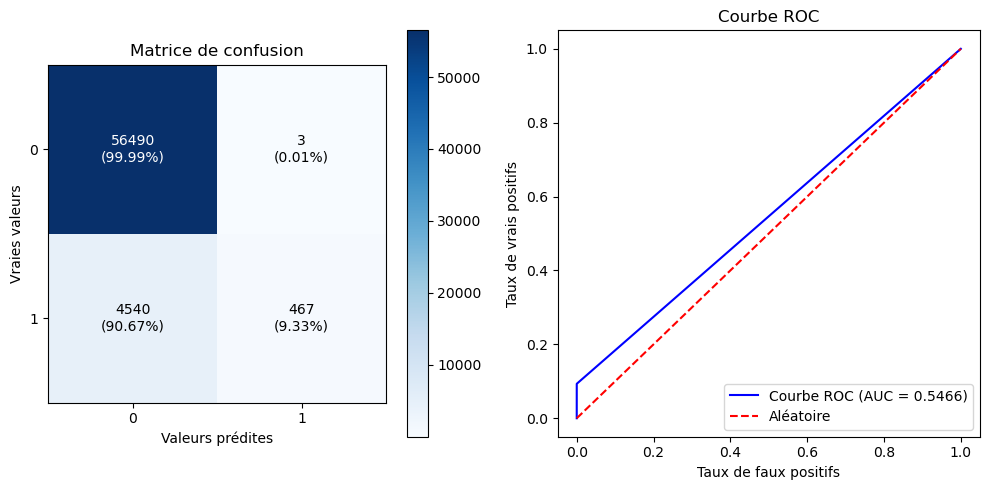

In [66]:
evaluate_model(gb_model, X_test, y_test)

## 5.5 XGBCClassifier

In [7]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, classification_report

# Création du modèle XGBoost Classifier
xgb_model = XGBClassifier(n_estimators=100, random_state=42)

# Entraînement du modèle sur les données d'entraînement
xgb_model.fit(X_train, y_train)

# Prédictions sur les données de test
predictions = xgb_model.predict(X_test)

# Calcul de l'AUC-ROC
roc_auc = roc_auc_score(y_test, xgb_model.predict_proba(X_test)[:, 1])
print('AUC : %0.4f' % roc_auc)

# Affichage du rapport de classification
print(classification_report(y_test, predictions, zero_division=0))


AUC : 0.7764
              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97     56493
         1.0       0.99      0.29      0.45      5007

    accuracy                           0.94     61500
   macro avg       0.97      0.65      0.71     61500
weighted avg       0.95      0.94      0.93     61500



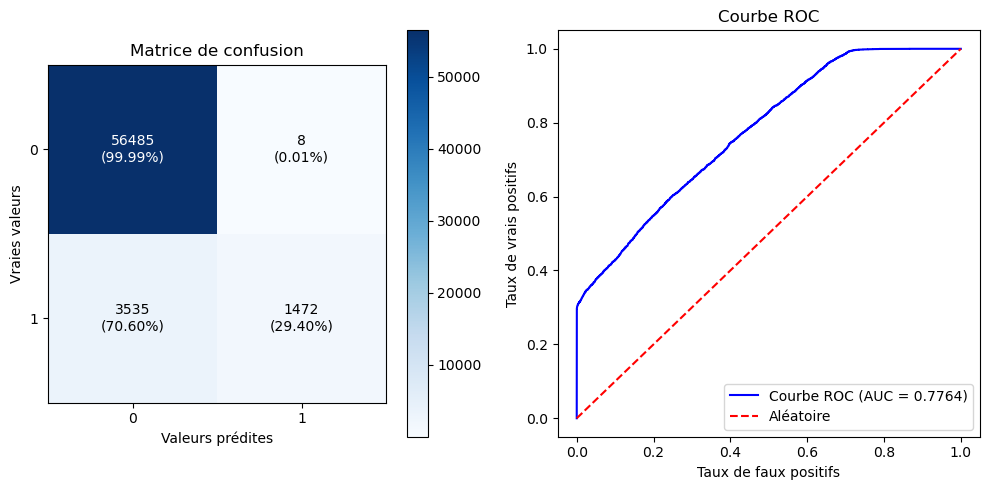

In [33]:
evaluate_model(xgb_model, X_test, y_test, threshold=0.5)

# 6. Rééquilibrage

Jeux de donnée déséquilibré :  Trois méthodes distinctes ont été mises en œuvre pour assurer une représentation équitable des classes. 
- La première méthode, le sous-échantillonnage, a réduit la classe majoritaire pour l'aligner avec la classe minoritaire. 
- La deuxième méthode, le suréchantillonnage, a augmenté la taille de la classe minoritaire pour qu'elle soit équivalente à la classe majoritaire. 
 - la troisième méthode a fait appel à des techniques synthétiques, comme SMOTE, pour générer de nouvelles instances de la classe minoritaire. 

Outre ces méthodes, une métrique personnalisée a été créée pour pénaliser davantage les faux négatifs , reflétant leur coût plus élevé pour l'application. En effet, dans notre contexte, le cout lié à un client qui fait défaut est 10 fois plus important que le manque à gagner d'un client à qui on a refusé l'octroi d'un crédit. 

In [11]:
from sklearn.metrics import make_scorer

def custom_metric(y_true, y_pred): 
    tp = sum((y_true == 1) & (y_pred == 1))
    tn = sum((y_true == 0) & (y_pred == 0))
    fp = sum((y_true == 0) & (y_pred == 1))
    fn = sum((y_true == 1) & (y_pred == 0))
    
    return -(10 * fn + fp)

# Create a custom scorer using your custom metric
#custom_scorer = make_scorer(custom_metric, greater_is_better=True)

## 6.1 Oversampling 

#### XGBClassifier 

In [12]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
# Créez un pipeline avec suréchantillonnage SMOTE suivi de XGBClassifier
pipeline = Pipeline([
    ('smote', SMOTE(random_state=2)),
    ('xgb', XGBClassifier())
])

# Définition des hyperparamètres à rechercher (ajoutez 'xgb__' devant chaque paramètre pour le spécifier à XGBClassifier dans le pipeline)
parameters = {
    'xgb__learning_rate': [0.01, 0.1],
    'xgb__n_estimators': [100, 200],
    'xgb__max_depth': [3, 5],
}


# Création de l'objet GridSearchCV
grid_search_smote = GridSearchCV(pipeline, parameters)

# Entraînement du modèle avec GridSearchCV sur l'ensemble d'entraînement d'origine
grid_search_smote.fit(X_train, y_train)

# Sélection du meilleur modèle
best_model_smote = grid_search_smote.best_estimator_

# Prédictions sur les données de test
predictions_smote = best_model_smote.predict(X_test)

# Calcul de l'AUC-ROC
roc_auc_smote = roc_auc_score(y_test, best_model_smote.predict_proba(X_test)[:, 1])
print('AUC : %0.4f' % roc_auc_smote)

# Affichage du rapport de classification
print(classification_report(y_test, predictions_smote, zero_division=0))

custom_score_smote = custom_metric(y_test, predictions_smote)
print(f"Custom Metric Score: {custom_score_smote}")


AUC : 0.7503
              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97     56493
         1.0       1.00      0.28      0.44      5007

    accuracy                           0.94     61500
   macro avg       0.97      0.64      0.70     61500
weighted avg       0.94      0.94      0.93     61500

Custom Metric Score: -36150


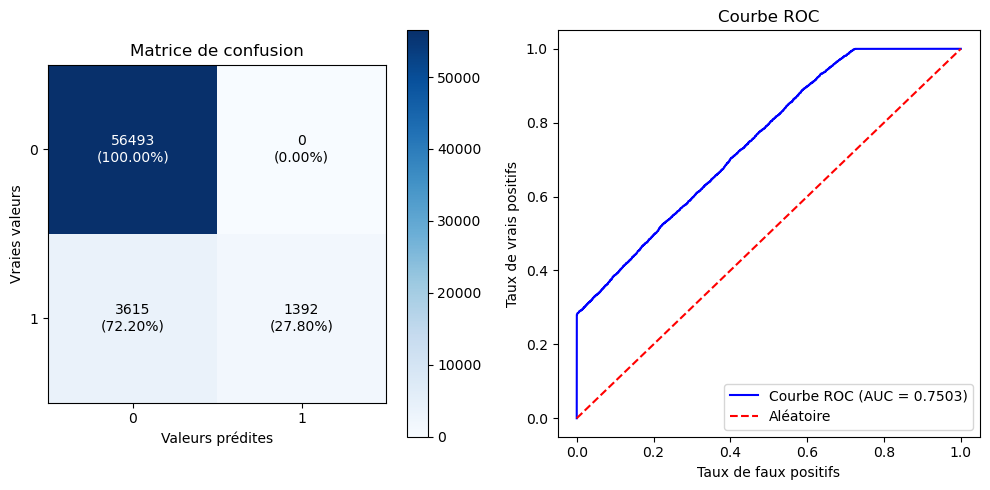

In [38]:
# Évaluation du modèle sur l'ensemble de test
evaluate_model(best_model_smote, X_test, y_test, threshold=0.5)

## 6.2 Undersampling

In [16]:
from imblearn.under_sampling import RandomUnderSampler
# Définissez le pipeline
pipeline = Pipeline([
    ('rus', RandomUnderSampler(random_state=42)),
    ('xgb', XGBClassifier())
])

# Paramètres pour la recherche par grille
parameters = {
    'xgb__learning_rate': [0.01, 0.05],
    'xgb__n_estimators': [100, 200],
    'xgb__max_depth': [3, 5],
}

# Créez l'objet GridSearchCV
grid_search_unders = GridSearchCV(pipeline, parameters, cv=5, n_jobs=-1)

# Entraînez le modèle
grid_search_unders.fit(X_train, y_train)

# Sélection du meilleur modèle
best_model_unders = grid_search_unders.best_estimator_

# Prédictions sur les données de test
predictions_unders = best_model_unders.predict(X_test)

# Calcul de l'AUC-ROC
roc_auc_unders = roc_auc_score(y_test, best_model_unders.predict_proba(X_test)[:, 1])
print('AUC : %0.4f' % roc_auc_unders)

# Affichage du rapport de classification
print(classification_report(y_test, predictions_unders, zero_division=0))

custom_score_unders = custom_metric(y_test, predictions_unders)
print(f"Custom Metric Score: {custom_score_unders}")


AUC : 0.7524
              precision    recall  f1-score   support

         0.0       0.95      0.71      0.81     56493
         1.0       0.15      0.59      0.24      5007

    accuracy                           0.70     61500
   macro avg       0.55      0.65      0.53     61500
weighted avg       0.89      0.70      0.77     61500

Custom Metric Score: -36728


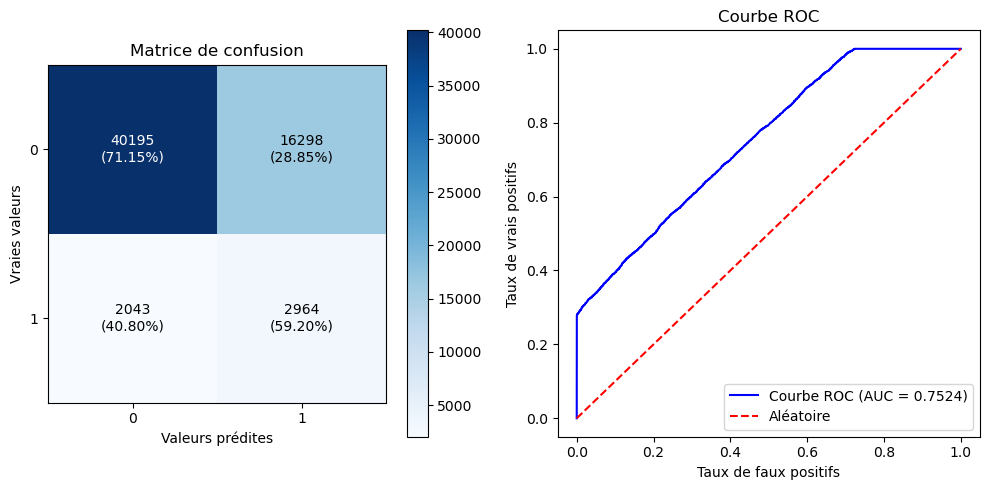

In [34]:
# Évaluation du modèle sur l'ensemble de test
evaluate_model(best_model_unders, X_test, y_test, threshold=0.5)

## 6.3 Class_weight

In [19]:
from sklearn.utils.class_weight import compute_class_weight

# Calculez les poids de classes
weights = compute_class_weight('balanced', classes=[0, 1], y=y_train)
class_weights = {0: weights[0], 1: weights[1]}

# Paramètres pour XGBoost avec prise en compte des poids de classes
parameters = {
    'xgb__learning_rate': [0.01, 0.05],
    'xgb__n_estimators': [100, 200],
    'xgb__max_depth': [3, 5],
    'xgb__scale_pos_weight': [class_weights[1]/class_weights[0]]
}

# Création du pipeline (sans rééchantillonnage cette fois)
pipeline = Pipeline([
    ('xgb', XGBClassifier())
])

# Création de l'objet GridSearchCV
grid_search_weighted = GridSearchCV(pipeline, parameters, cv=5, n_jobs=-1)

# Entraînement du modèle
grid_search_weighted.fit(X_train, y_train)

# Sélection du meilleur modèle
best_model_weighted = grid_search_weighted.best_estimator_

# Prédictions sur les données de test
predictions_weighted = best_model_weighted.predict(X_test)

# Calcul de l'AUC-ROC
roc_auc_weighted = roc_auc_score(y_test, best_model_weighted.predict_proba(X_test)[:, 1])
print('AUC : %0.4f' % roc_auc_weighted)

# Affichage du rapport de classification
print(classification_report(y_test, predictions_weighted, zero_division=0))

custom_score_weighted = custom_metric(y_test, predictions_weighted)
print(f"Custom Metric Score: {custom_score_weighted}")


AUC : 0.7468
              precision    recall  f1-score   support

         0.0       0.95      0.79      0.86     56493
         1.0       0.17      0.50      0.26      5007

    accuracy                           0.77     61500
   macro avg       0.56      0.64      0.56     61500
weighted avg       0.88      0.77      0.81     61500

Custom Metric Score: -37126


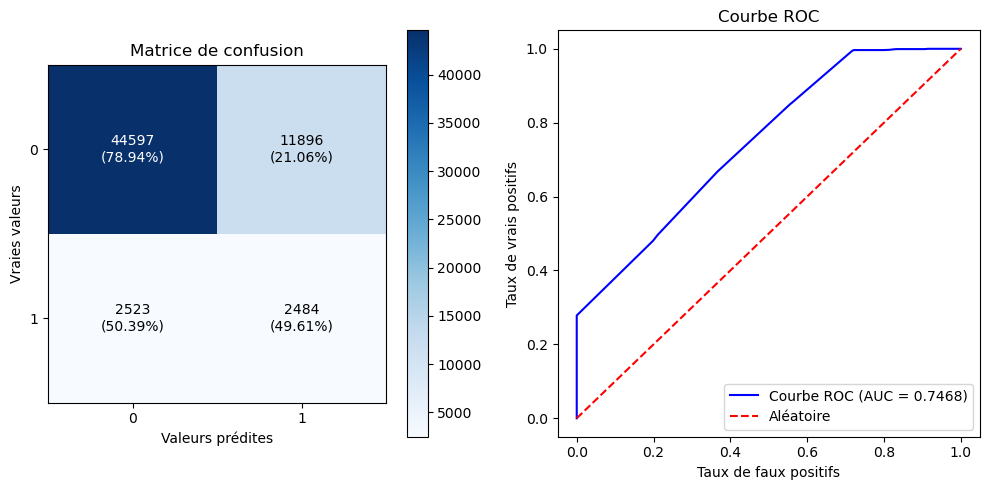

In [28]:
# Évaluation du modèle sur l'ensemble de test
evaluate_model(best_model_weighted, X_test, y_test)

In [23]:
metrics_data = {
    'AUC': {
        'class_weight': roc_auc_weighted,
        'Over_sampling': roc_auc,
        'Under_sampling': roc_auc_unders
    },
    'Precision': {
        'class_weight': classification_report(y_test, predictions_weighted, output_dict=True)['1.0']['precision'],
        'Over_sampling': classification_report(y_test, predictions_smote, output_dict=True)['1.0']['precision'],
        'Under_sampling': classification_report(y_test, predictions_unders, output_dict=True)['1.0']['precision']
    },
    'Recall': {
        'class_weight': classification_report(y_test, predictions_weighted, output_dict=True)['1.0']['recall'],
        'Over_sampling': classification_report(y_test, predictions_smote, output_dict=True)['1.0']['recall'],
        'Under_sampling': classification_report(y_test, predictions_unders, output_dict=True)['1.0']['recall']
    },
    'F1-score': {
        'class_weight': classification_report(y_test, predictions_weighted, output_dict=True)['1.0']['f1-score'],
        'Over_sampling': classification_report(y_test, predictions_smote, output_dict=True)['1.0']['f1-score'],
        'Under_sampling': classification_report(y_test, predictions_unders, output_dict=True)['1.0']['f1-score']
    },
    'Custom Score': {
        'class_weight': custom_score_weighted,
        'Over_sampling': custom_score_smote,
        'Under_sampling': custom_score_unders
    }
}

# Convertir le dictionnaire en DataFrame
df = pd.DataFrame(metrics_data)

# Afficher le tableau récapitulatif
print(df)



                     AUC  Precision    Recall  F1-score  Custom Score
class_weight    0.746808   0.172740  0.496105  0.256254        -37126
Over_sampling   0.776396   1.000000  0.278011  0.435068        -36150
Under_sampling  0.752402   0.153878  0.591971  0.244262        -36728


Trois méthodes différentes de gestion du déséquilibre des classes sur un ensemble de données : l'utilisation de poids de classes (`class_weight`), le suréchantillonnage (`Over_sampling`) et le sous-échantillonnage (`Under_sampling`).

1. **AUC (Area Under the Curve)** : L'AUC, qui est une métrique clé pour les problèmes de classification, est le plus élevé pour la méthode de suréchantillonnage, ce qui indique que cette méthode a le meilleur compromis entre le taux de faux positifs et le taux de vrais positifs. Cependant, les différences entre les trois méthodes ne sont pas très importantes, avec seulement 3% entre la meilleure et la moins bonne.

2. **Precision** : La précision est la plus élevée pour le suréchantillonnage, qui atteint une précision parfaite de 1,00. Cela signifie que toutes les prédictions positives du modèle sont effectivement positives. Toutefois, cette valeur parfaite doit être interprétée avec prudence, car elle peut également indiquer que le modèle prédit très peu de cas positifs, comme le suggère le rappel associé.

3. **Recall** : Le rappel est le plus élevé pour le sous-échantillonnage, ce qui suggère que cette méthode est la meilleure pour identifier la classe minoritaire. C'est important si le coût des faux négatifs est élevé.

4. **F1-score** : Le suréchantillonnage a le score F1 le plus élevé, ce qui signifie qu'il a le meilleur équilibre entre la précision et le rappel parmi les trois méthodes. Cependant, la valeur reste relativement faible, suggérant qu'il y a encore des améliorations à apporter.

5. **Custom Score** : Le score personnalisé, qui pénalise davantage les faux négatifs, est le plus bas (ce qui est mieux compte tenu de la manière dont il est conçu) pour le suréchantillonnage, bien que les différences entre les méthodes ne soient pas très prononcées.

En conclusion, bien que le suréchantillonnage semble offrir la meilleure performance globale en termes d'AUC et de F1-score, le sous-échantillonnage offre un rappel nettement plus élevé.


In [7]:
from imblearn.under_sampling import RandomUnderSampler
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, classification_report

# Étape 1: Undersampling
rus = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

# Étape 2: Ré-estimation du modèle avec les nouveaux paramètres
xgb_model = XGBClassifier(learning_rate=0.05, max_depth=5, n_estimators=100, random_state=42)
xgb_model.fit(X_train_resampled, y_train_resampled)

# Prédictions
predictions = xgb_model.predict(X_test)

# Calcul de l'AUC-ROC
roc_auc = roc_auc_score(y_test, xgb_model.predict_proba(X_test)[:, 1])
print('AUC : %0.4f' % roc_auc)

# Affichage du rapport de classification
print(classification_report(y_test, predictions, zero_division=0))

AUC : 0.7524
              precision    recall  f1-score   support

         0.0       0.95      0.71      0.81     56493
         1.0       0.15      0.59      0.24      5007

    accuracy                           0.70     61500
   macro avg       0.55      0.65      0.53     61500
weighted avg       0.89      0.70      0.77     61500



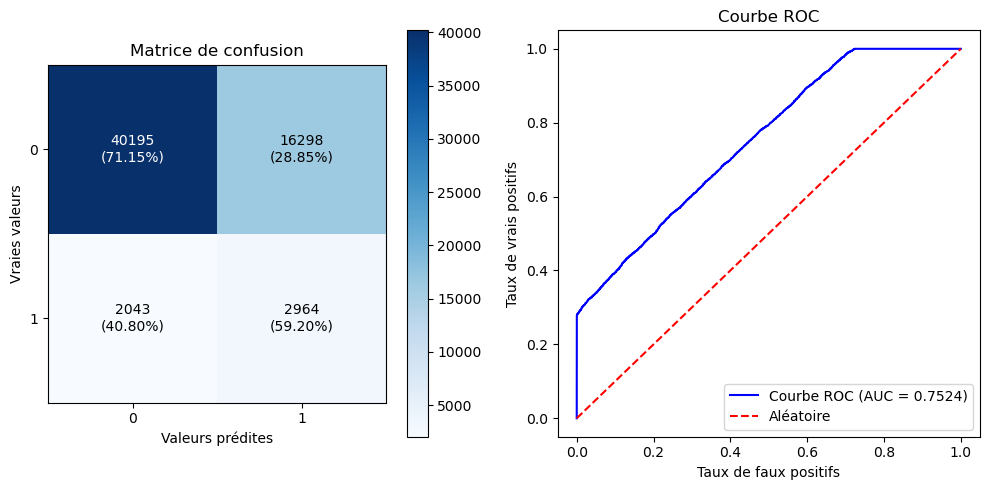

In [8]:
# Évaluation du modèle sur l'ensemble de test
evaluate_model(xgb_model, X_test, y_test)

## 6.4. Modification de seuil

In [54]:
def plot_metrics_by_threshold(model, X_test, y_test, custom_metric_function):
    thresholds = np.linspace(0.1, 0.9, 9)
    recalls = []
    custom_scores = []

    probas = model.predict_proba(X_test)[:, 1]
    
    for threshold in thresholds:
        predictions = (probas >= threshold).astype(int)
        recalls.append(recall_score(y_test, predictions))
        custom_scores.append(custom_metric_function(y_test, predictions))

    fig, ax1 = plt.subplots(figsize=(12, 3))

    ax1.set_xlabel('Threshold')
    ax1.set_ylabel('Recall', color='tab:blue')
    ax1.plot(thresholds, recalls, 'o-', color='tab:blue', label="Recall")
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    ax2 = ax1.twinx()  
    ax2.set_ylabel('Custom Score', color='tab:red')
    ax2.plot(thresholds, custom_scores, 's-', color='tab:red', label="Custom Score")
    ax2.tick_params(axis='y', labelcolor='tab:red')

    fig.tight_layout()  
    plt.title('Recall and Custom Score by Threshold')
    plt.show()

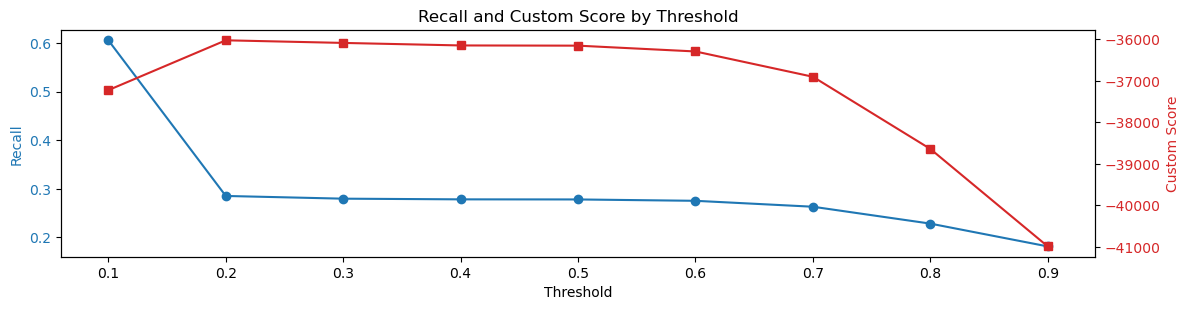

In [55]:
plot_metrics_by_threshold(best_model_smote, X_test, y_test, custom_metric)

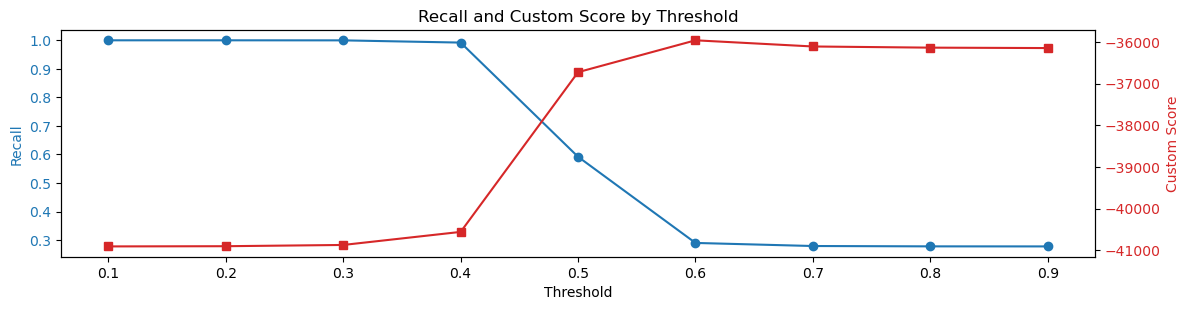

In [56]:
plot_metrics_by_threshold(best_model_unders, X_test, y_test, custom_metric)

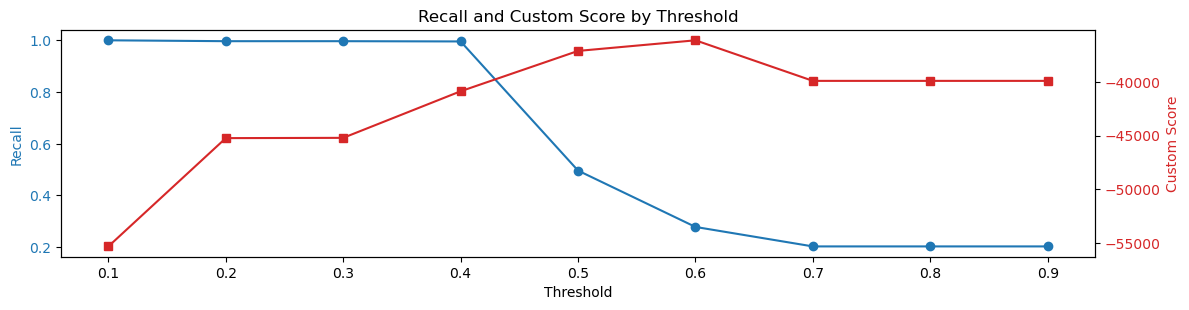

In [57]:
plot_metrics_by_threshold(best_model_weighted, X_test, y_test, custom_metric)

In [58]:
print(grid_search_unders.best_params_)

{'xgb__learning_rate': 0.05, 'xgb__max_depth': 5, 'xgb__n_estimators': 100}


En conclusion, notre choix se porte sur le modèle XGBoost avec la stratégie de sous-échantillonnage, en combinaison avec la configuration : `{'xgb__learning_rate': 0.05, 'xgb__max_depth': 5, 'xgb__n_estimators': 100} `. Ce modèle nous offre un équilibre approprié entre la performance, la précision et le rappel, tout en minimisant efficacement les erreurs de classification.

## 6.5. Features importance

### Features importance

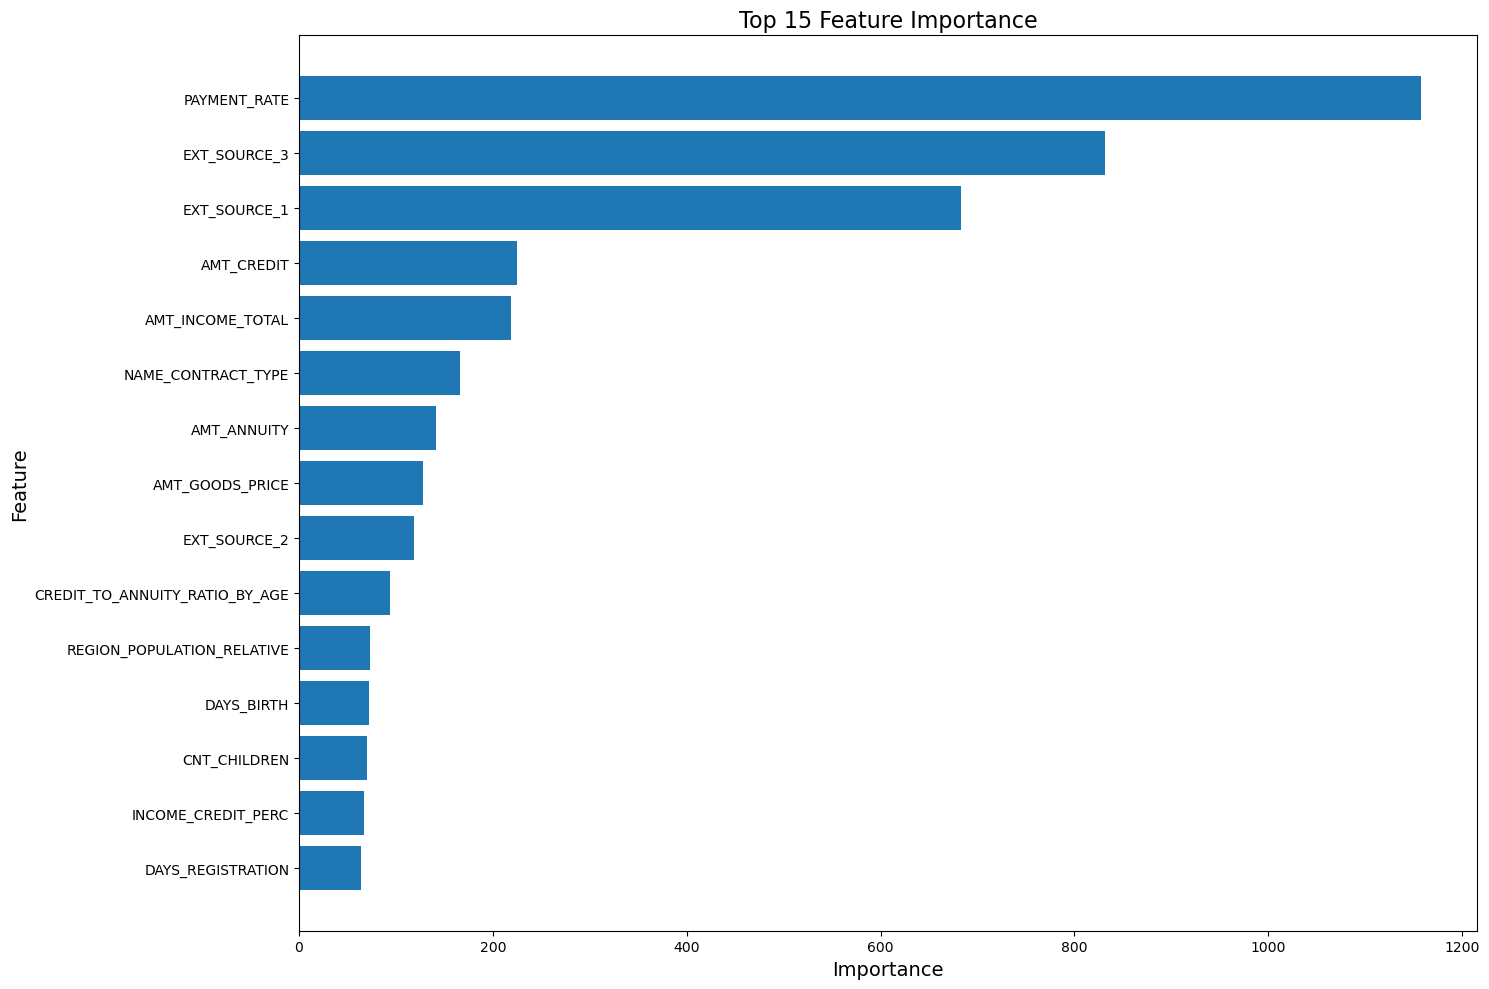

In [12]:
# Obtention des importances des fonctionnalités
importances = best_model_unders.named_steps['xgb'].feature_importances_  # On accède au modèle XGB dans le pipeline
feature_names = X_train.columns  

# Tri des fonctionnalités par importance décroissante
indices = np.argsort(importances)[::-1]
sorted_feature_names = [feature_names[i] for i in indices[:15]]  # Prendre uniquement les 15 premiers
sorted_importances = importances[indices[:15]]  # Prendre uniquement les 15 premiers

# Affichage des importances des fonctionnalités
plt.figure(figsize=(15, 10))
plt.barh(range(len(sorted_importances)), sorted_importances, tick_label=sorted_feature_names, align='center')
plt.gca().invert_yaxis()  # Pour afficher la caractéristique la plus importante en haut
plt.ylabel('Feature', fontsize=14)
plt.xlabel('Importance', fontsize=14)
plt.title('Top 15 Feature Importance', fontsize=16)
plt.tight_layout()
plt.show()


[04:01:55] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
100%|===================| 61230/61500 [02:29<00:00]        

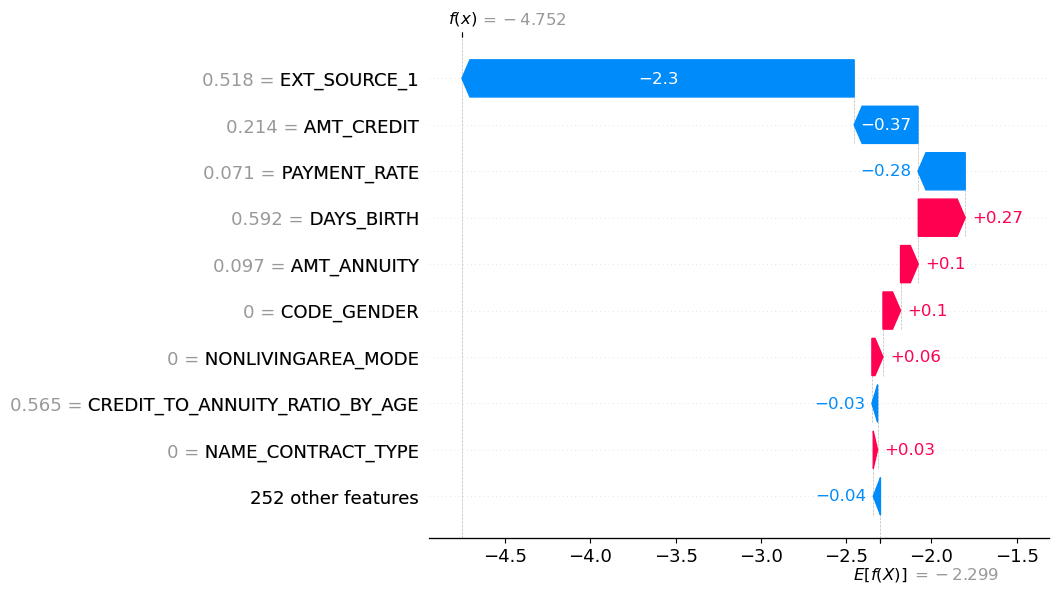

In [24]:
import shap

model_xgb = best_model_unders.named_steps['xgb']
# Créer l'objet explainer SHAP
explainer = shap.Explainer(model_xgb, X_train, check_additivity=False)

# Calculer les valeurs SHAP pour les données de test
shap_values = explainer(X_test)

# Afficher le graphique en cascade pour la première instance de l'ensemble de test
shap.plots.waterfall(shap_values[0])


# 7. Modèle final et exportation

In [25]:
import pickle

with open('shap_values.pkl', 'wb') as f:
    pickle.dump(shap_values, f)


In [26]:
shap_df = pd.DataFrame(shap_values.values, columns=X_test.columns)
shap_df.to_csv('shap_values.csv', index=False)


In [62]:
import joblib

# Création du pipeline
pipeline = Pipeline([
    ('under_sampler', RandomUnderSampler(random_state=42)),
    ('classifier', XGBClassifier(learning_rate=0.05, max_depth=5, n_estimators=100))
])


In [63]:
# Entraînement du modèle avec les données d'entraînement
pipeline.fit(X_train, y_train)

Pipeline(steps=[('under_sampler', RandomUnderSampler(random_state=42)),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=5, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=100, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [64]:
# Sauvegarde du pipeline
joblib.dump(pipeline, 'pipeline_model.joblib')

['pipeline_model.joblib']

In [68]:
from mlflow.models.signature import infer_signature

signature = infer_signature(X_train, y_train)



/home/ayad/anaconda3/envs/projet7/lib/python3.8/site-packages/mlflow/models/signature.py:212: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input) if model_input is not None else None


In [69]:
import mlflow.sklearn

mlflow.sklearn.save_model(pipeline, 'mlflow_model', signature=signature)

/home/ayad/anaconda3/envs/projet7/lib/python3.8/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


# 8. Data Drift

In [11]:
from IPython.display import HTML
from evidently import ColumnMapping
from evidently.report import Report
from evidently.metric_preset import DataDriftPreset

# Prepare your data
reference = train.drop(columns=['TARGET'])  # Drop the 'TARGET' column
current = test

# Define the column mapping
column_mapping = ColumnMapping()
column_mapping.features = list(current.columns)  # Use all columns in 'test' as features

# Generate a Data Drift report
data_drift_report = Report(metrics=[DataDriftPreset()])
data_drift_report.run(current_data=current, reference_data=reference, column_mapping=column_mapping)

# Get the HTML of the report
report_html = data_drift_report.get_html()

# Display the report
HTML(report_html)





In [12]:
# Save the report to a file
with open('report.html', 'w') as f:
    f.write(report_html)